# Processing gravity data with Harmonica


In this tutorial we’ll take a tour around Harmonica, a Python library for forward modelling, inversion and processing gravity data, focusing on the processing workflow to produce a regular grid of the Bouguer gravity disturbance. 


To obtain the _Bouguer gravity disturbance_, it is necessary to calculate the _gravity disturbance_ as:
$$ \delta g(P) = g(P) - \gamma (P), $$
where $g(P)$ and $\gamma(P)$ are the observed gravity and normal gravity at point $P$ respectively.

Then, the gravitational effect produced by the known topography masses  is removed to obtain the _Bouguer gravity disturbance_ as:
$$ \delta bg(P) = \delta g(P) - g_{topo}(P), $$
where $g_{topo}(P)$ is the gravitational effect of the topography at point $P$. 

# Study Area

The **Bushveld Igneous Complex** is located in South Africa. 
It is the largest layered igneous intrusion within the Earth's crust.
It has been tilted and eroded forming the outcrops around what appears to be the edge of a great geological basin: the Transvaal Basin. 
It is approximately 2 billion years old and is divided into four different limbs: the northern, southern, eastern, and western limbs. 
The Bushveld Complex comprises the Rustenburg Layered suite, the Lebowa Granites and the Rooiberg Felsics, that are overlain by the Karoo sediments.

<img src="img/study-area.png">

_[Webb et al, (2004)](https://doi.org/10.2113/107.1-2.207)_

## Import libraries

In [1]:
import pygmt
import pyproj
import pooch
import numpy as np
import xarray as xr
import verde as vd
import boule as bl
import harmonica as hm
import matplotlib.pyplot as plt

## Load South Africa gravity data

In [2]:
data = hm.datasets.fetch_south_africa_gravity()
data

latitude  longitude  elevation    gravity
0     -34.39150   17.71900     -589.0  979724.79
1     -34.48000   17.76100     -495.0  979712.90
2     -34.35400   17.77433     -406.0  979725.89
3     -34.13900   17.78500     -267.0  979701.20
4     -34.42200   17.80500     -373.0  979719.00
...         ...        ...        ...        ...
14554 -17.95833   21.22500     1053.1  978182.09
14555 -17.98333   21.27500     1033.3  978183.09
14556 -17.99166   21.70833     1041.8  978182.69
14557 -17.95833   21.85000     1033.3  978193.18
14558 -17.94166   21.98333     1022.6  978211.38

[14559 rows x 4 columns]

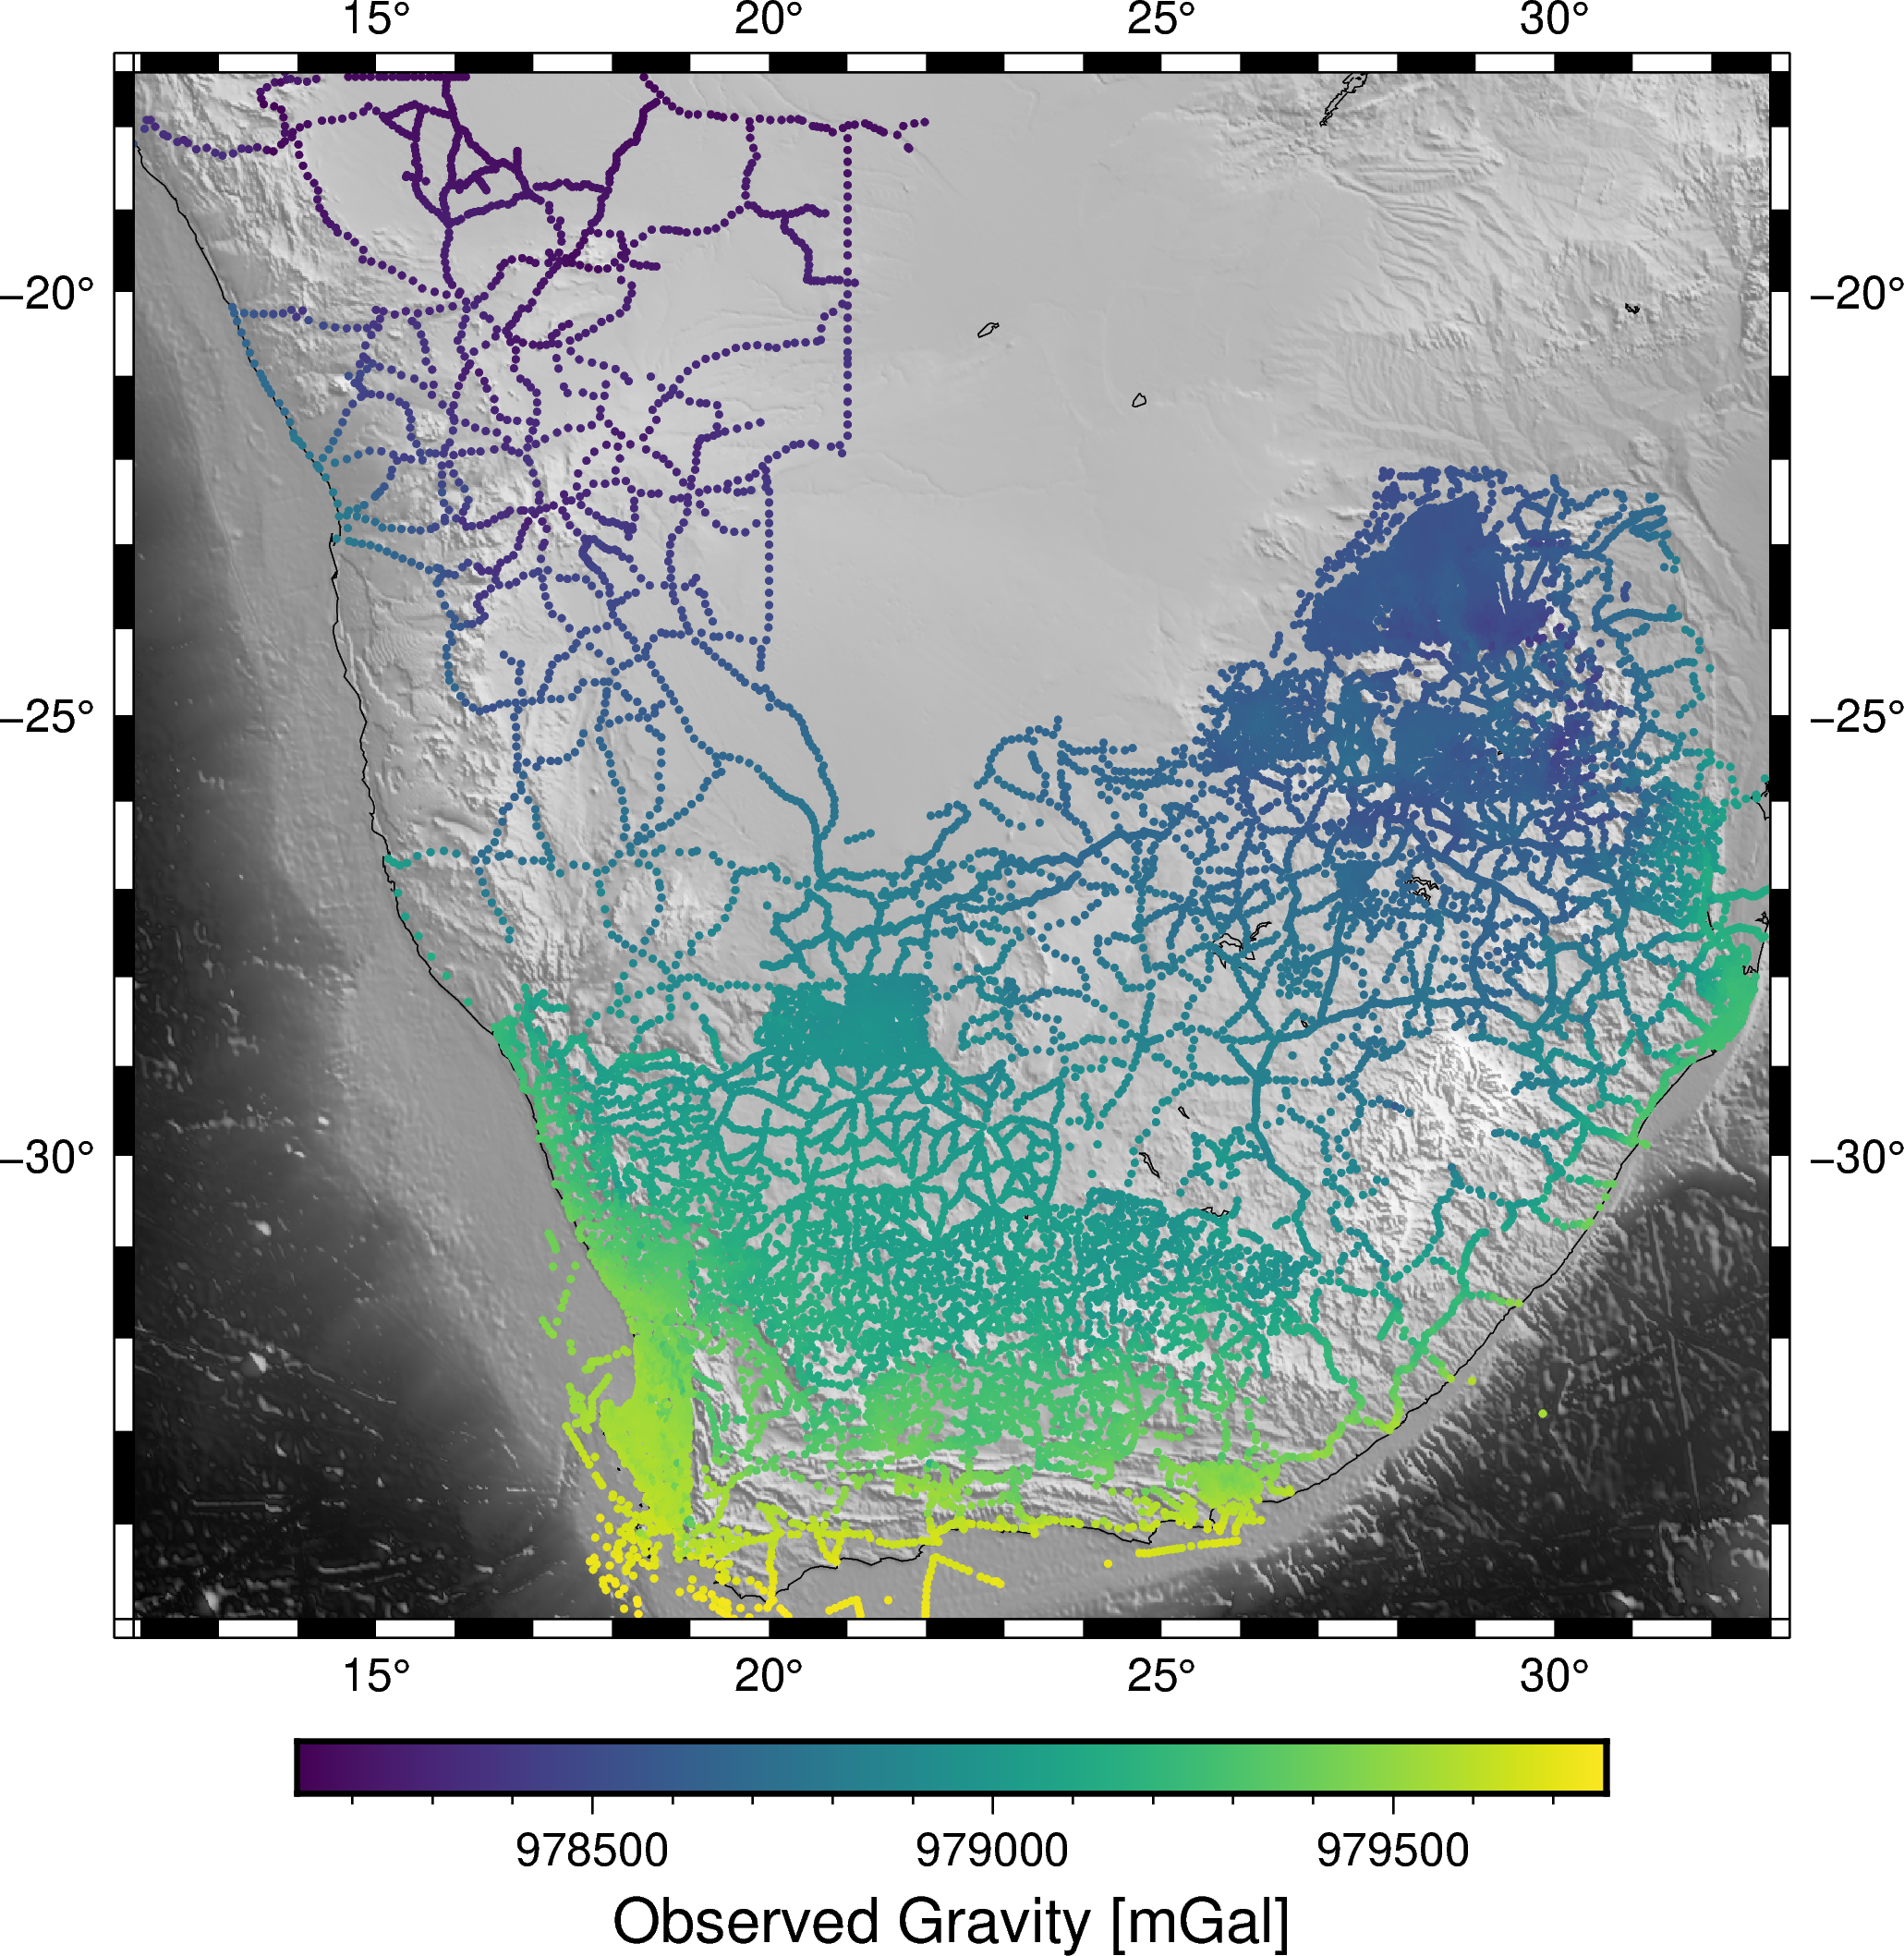

In [3]:
# Set projection for all plots:
projection_gmt="M15c"

# Obtain the region to plot using Verde ([W, E, S, N]):
region_deg = vd.get_region((data.longitude, data.latitude))

# Plot the observerd gravity using pygmt:
fig = pygmt.Figure()
fig.grdimage(
    "@earth_relief_01m",
    region=region_deg,
    projection=projection_gmt,
    shading="+a45+nt0.7",
    cmap="gray",
)
fig.coast(shorelines=True, region=region_deg)
pygmt.makecpt(cmap="viridis", series=[data.gravity.min(), data.gravity.max()])
fig.plot(x=data.longitude, y=data.latitude, color=data.gravity, cmap=True, style="c2p", projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Observed Gravity [mGal]"')
fig.show()

## Cut the dataset into a smaller region

We will cut the dataset into a smaller region using **[Verde](https://www.fatiando.org/verde)**.

In [4]:
# Set the region to cut ([W, E, S, N]):
region_deg = (25, 32, -27, -23)
 
# Get a array with dataset coordinates which are inside the region_cut: 
inside = vd.inside((data.longitude, data.latitude), region_deg)
# Get a smaller dataset and replace it in the original:
data = data[inside]
data

latitude  longitude  elevation    gravity
8848  -26.26334   25.01500    1230.16  978681.38
8849  -26.38713   25.01932    1297.00  978669.02
8850  -26.39667   25.02499    1304.84  978669.28
8851  -26.07668   25.04500    1165.24  978681.08
8852  -26.35001   25.07668    1262.47  978665.19
...         ...        ...        ...        ...
13174 -23.86333   31.51500     300.53  978776.85
13175 -23.30000   31.52499     280.72  978798.55
13176 -23.19333   31.54832     245.67  978803.55
13177 -23.84833   31.57333     226.77  978808.44
13757 -23.00000   31.37500     285.59  978734.77

[3877 rows x 4 columns]

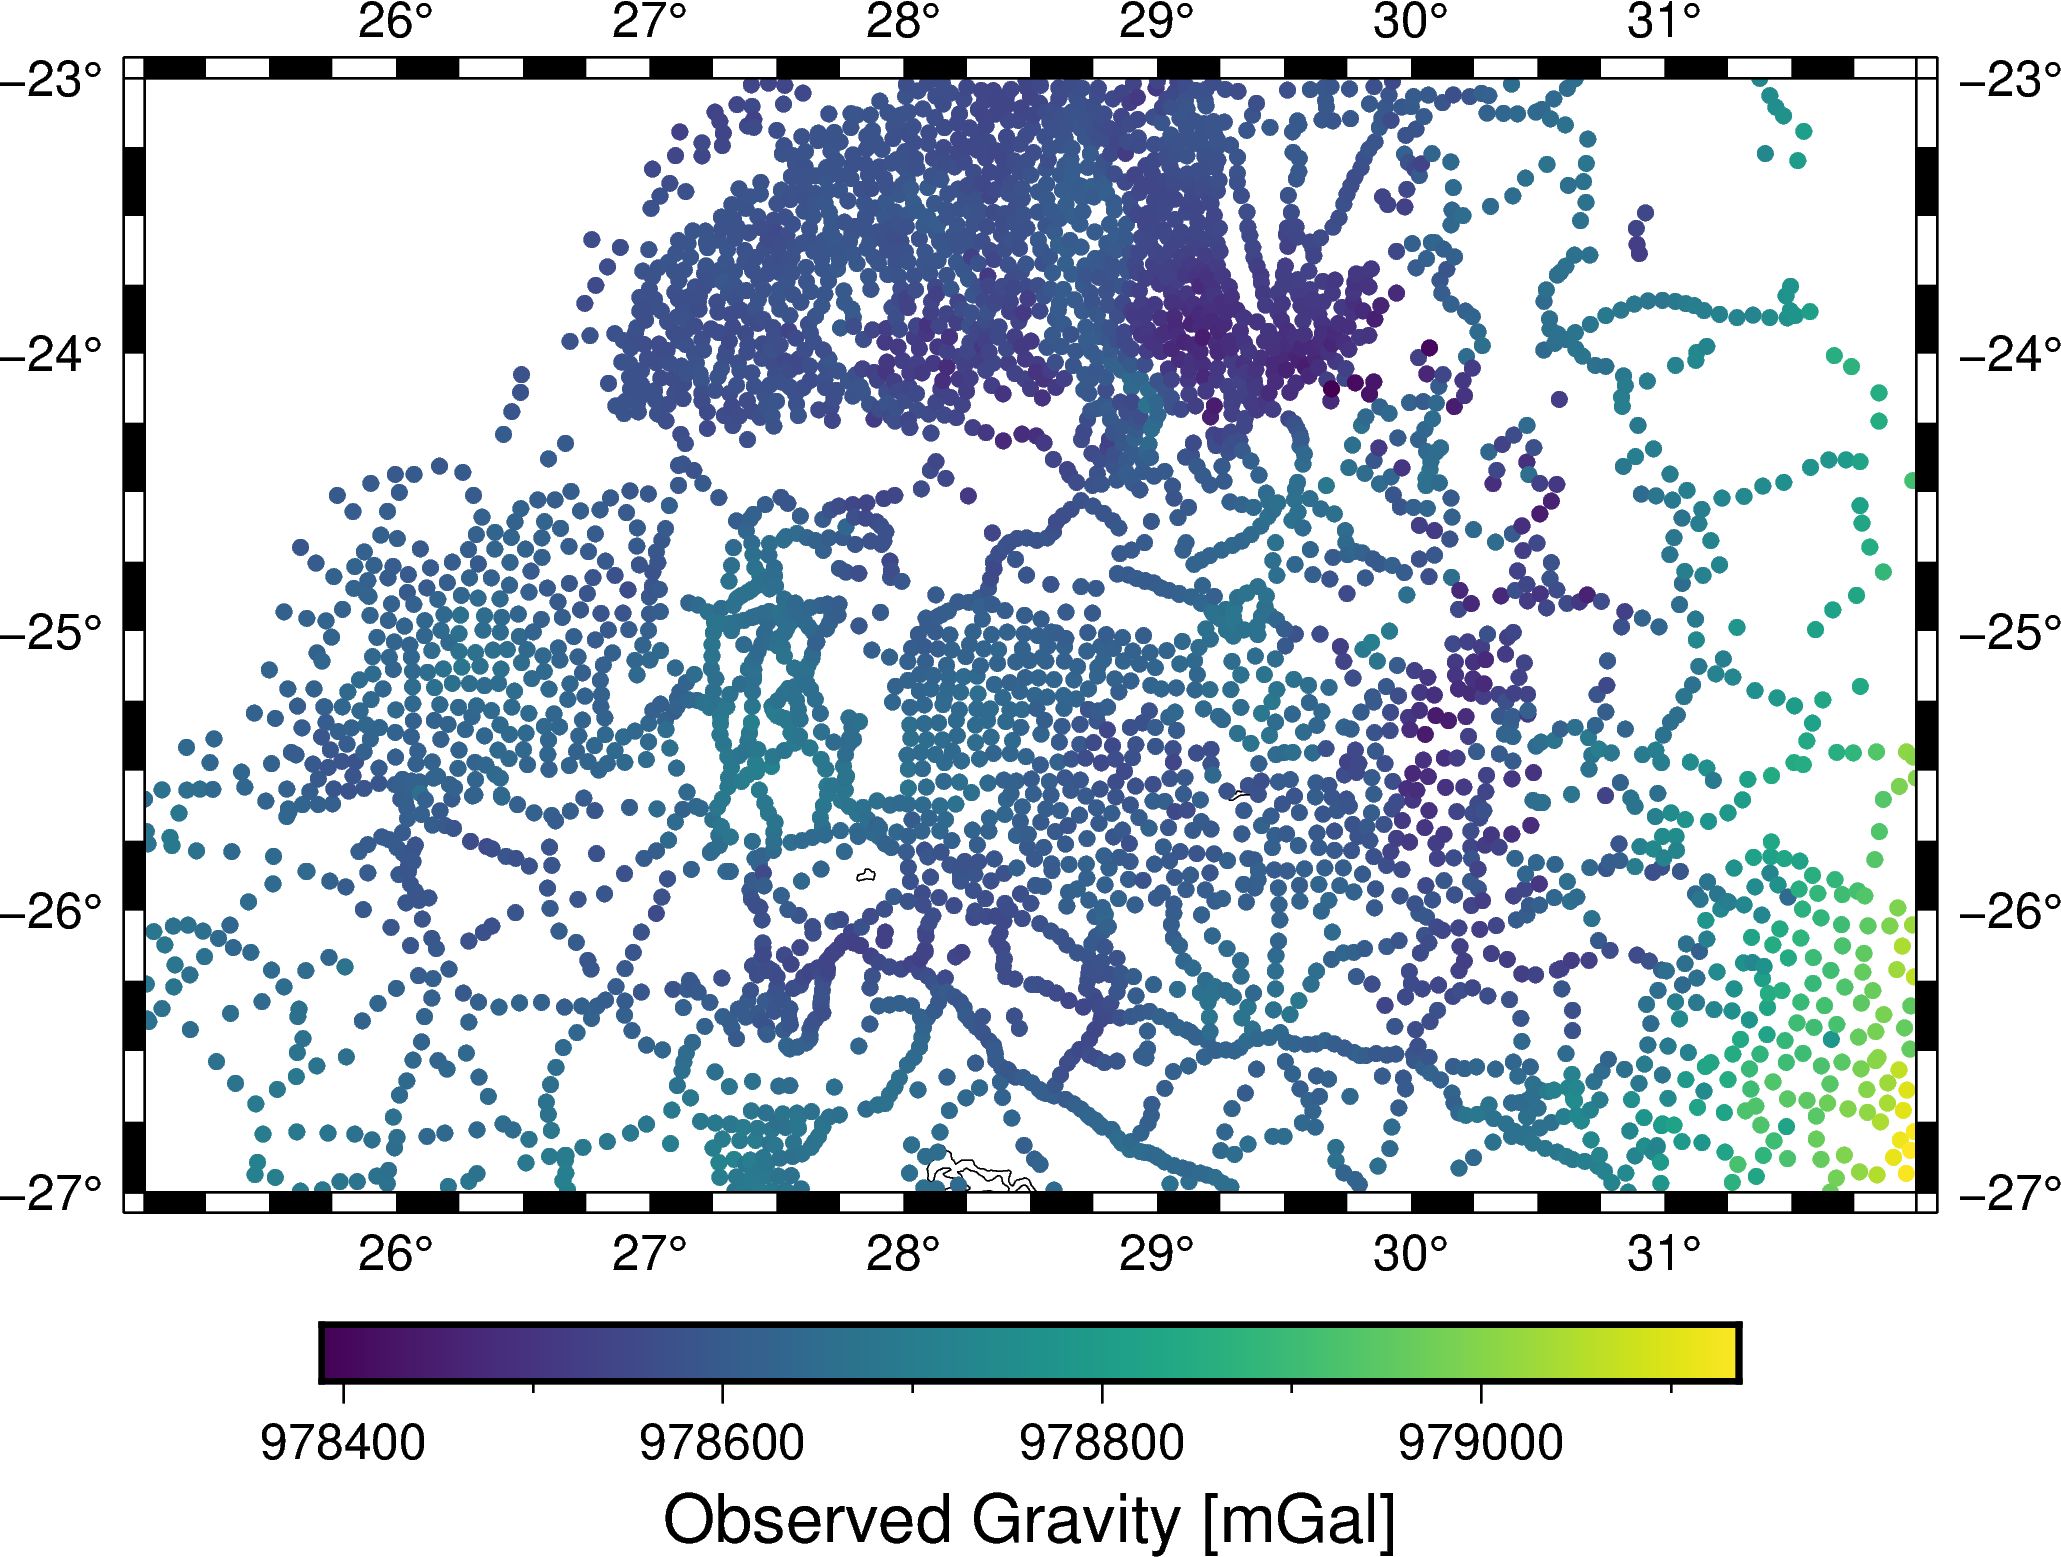

In [5]:
# Plot the gravity using pygmt:
region_deg = vd.get_region((data.longitude, data.latitude))

fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)
pygmt.makecpt(cmap="viridis", series=[data.gravity.min(), data.gravity.max()])
fig.plot(x=data.longitude, y=data.latitude, color=data.gravity, cmap=True, style="c4p", projection=projection_gmt)
fig.colorbar(frame='af+l"Observed Gravity [mGal]"')
fig.basemap(projection=projection_gmt, frame=True)
fig.show()

## Compute gravity disturbance

The gravity disturbance is defined as: 

$$ \delta g(P) = g(P) - \gamma(P), $$

The normal gravity $\gamma(P)$ is calculated using the reference ellipsoid _WGS84_.

We will use **[Boule](https://www.fatiando.org/boule)** to get the reference ellipsoid and calculate the normal gravity through
the `normal_gravity()` method. 
It implements the closed-form formula of [Li and Götze (2001)](http://mr.crossref.org/iPage?doi=10.1190%2F1.1487109) which can calculate normal gravity at any latitude and (geometric) height.

In [6]:
# Select the reference ellipsoid:
ell = bl.WGS84

# Calculate the gravity disturbance:
gravity_disturbance = data.gravity - ell.normal_gravity(data.latitude, data.elevation)
# Add the gravity_disturbance to the dataset as a columne: 
data = data.assign(gravity_disturbance=gravity_disturbance)
data

latitude  longitude  elevation    gravity  gravity_disturbance
8848  -26.26334   25.01500    1230.16  978681.38            16.654699
8849  -26.38713   25.01932    1297.00  978669.02            16.031458
8850  -26.39667   25.02499    1304.84  978669.28            18.024250
8851  -26.07668   25.04500    1165.24  978681.08             9.665660
8852  -26.35001   25.07668    1262.47  978665.19             4.215785
...         ...        ...        ...        ...                  ...
13174 -23.86333   31.51500     300.53  978776.85            -8.543559
13175 -23.30000   31.52499     280.72  978798.55            44.319034
13176 -23.19333   31.54832     245.67  978803.55            45.481540
13177 -23.84833   31.57333     226.77  978808.44             1.280373
13757 -23.00000   31.37500     285.59  978734.77             1.613859

[3877 rows x 5 columns]

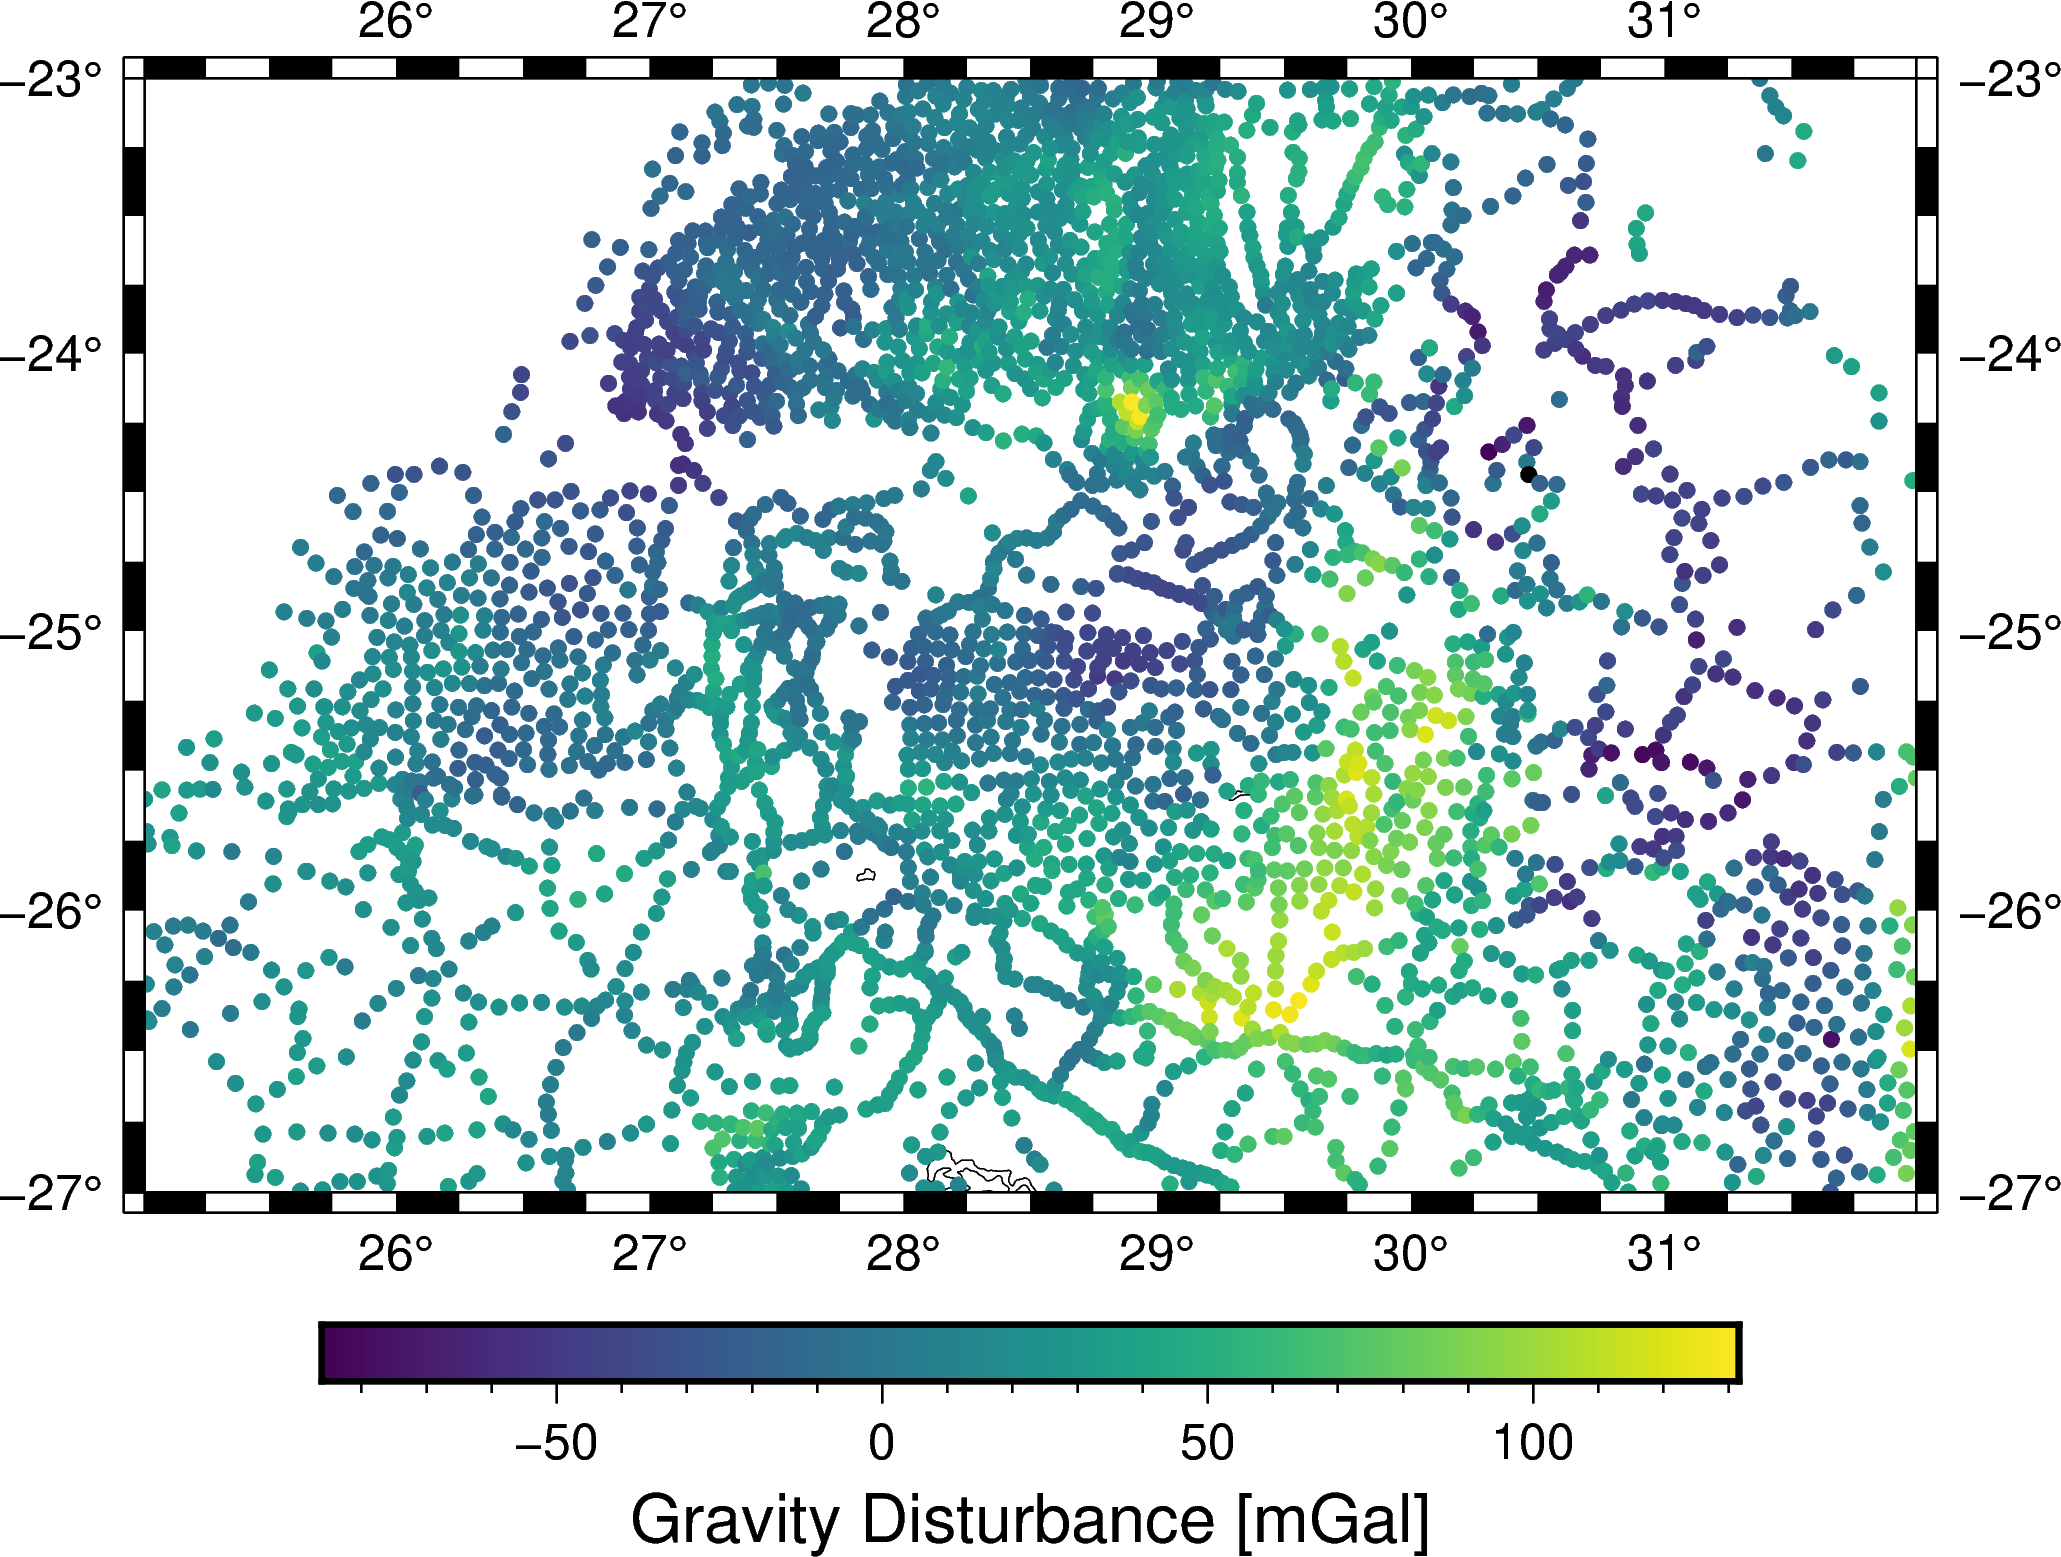

In [7]:
# Plot gravity disturbance using pygmt:
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

vmin, vmax = data.gravity_disturbance.min(), data.gravity_disturbance.max()
pygmt.makecpt(cmap="viridis", series=[vmin, vmax])
fig.plot(x=data.longitude, y=data.latitude, color=data.gravity_disturbance, cmap=True, style="c4p", projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Gravity Disturbance [mGal]"')
fig.show()

## Compute Bouguer gravity disturbance

The _Bouguer gravity disturbance_ is defined as:

$$ \delta bg(P) = \delta g(P) - g_{topo}(P) $$

The gravitational effect of the topography ($g_{topo}(P)$) is calculated in a plane Earth approximation by forward modelling using prisms. 

**Steps:**
* Load a digital elevation model (DEM) of the survey area.
* Project the data to plain coordinates.
* Compute Bouguer gravity disturbance by forward modelling the topography with prisms.

To do this, we will use **[Harmonica]( www.fatiando.org/harmonica )**.


### Load a DEM of South Africa (ETOPO1)

In [8]:
url = "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
fname = pooch.retrieve(url, known_hash=None, fname="bushveld_topography.nc")

topography = xr.load_dataset(fname)
topography

<xarray.Dataset>
Dimensions:    (latitude: 240, longitude: 419)
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Data variables:
    bedrock    (latitude, longitude) float64 1.257e+03 1.26e+03 ... 241.0 238.0
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1 Bedrock Relief
    GMT_version:  4.4.0
    node_offset:  0
    doi:          10.7289/V5C8276M

In [9]:
# Extract the topography as a xarray.DataArray:
topography = topography.bedrock
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

grdinfo [WARNING]: The x-coordinates and range attribute are in conflict but range is exactly 360; we rely on this range
grdinfo [WARNING]: The y-coordinates and range attribute are in conflict but range is exactly 180; we rely on this range


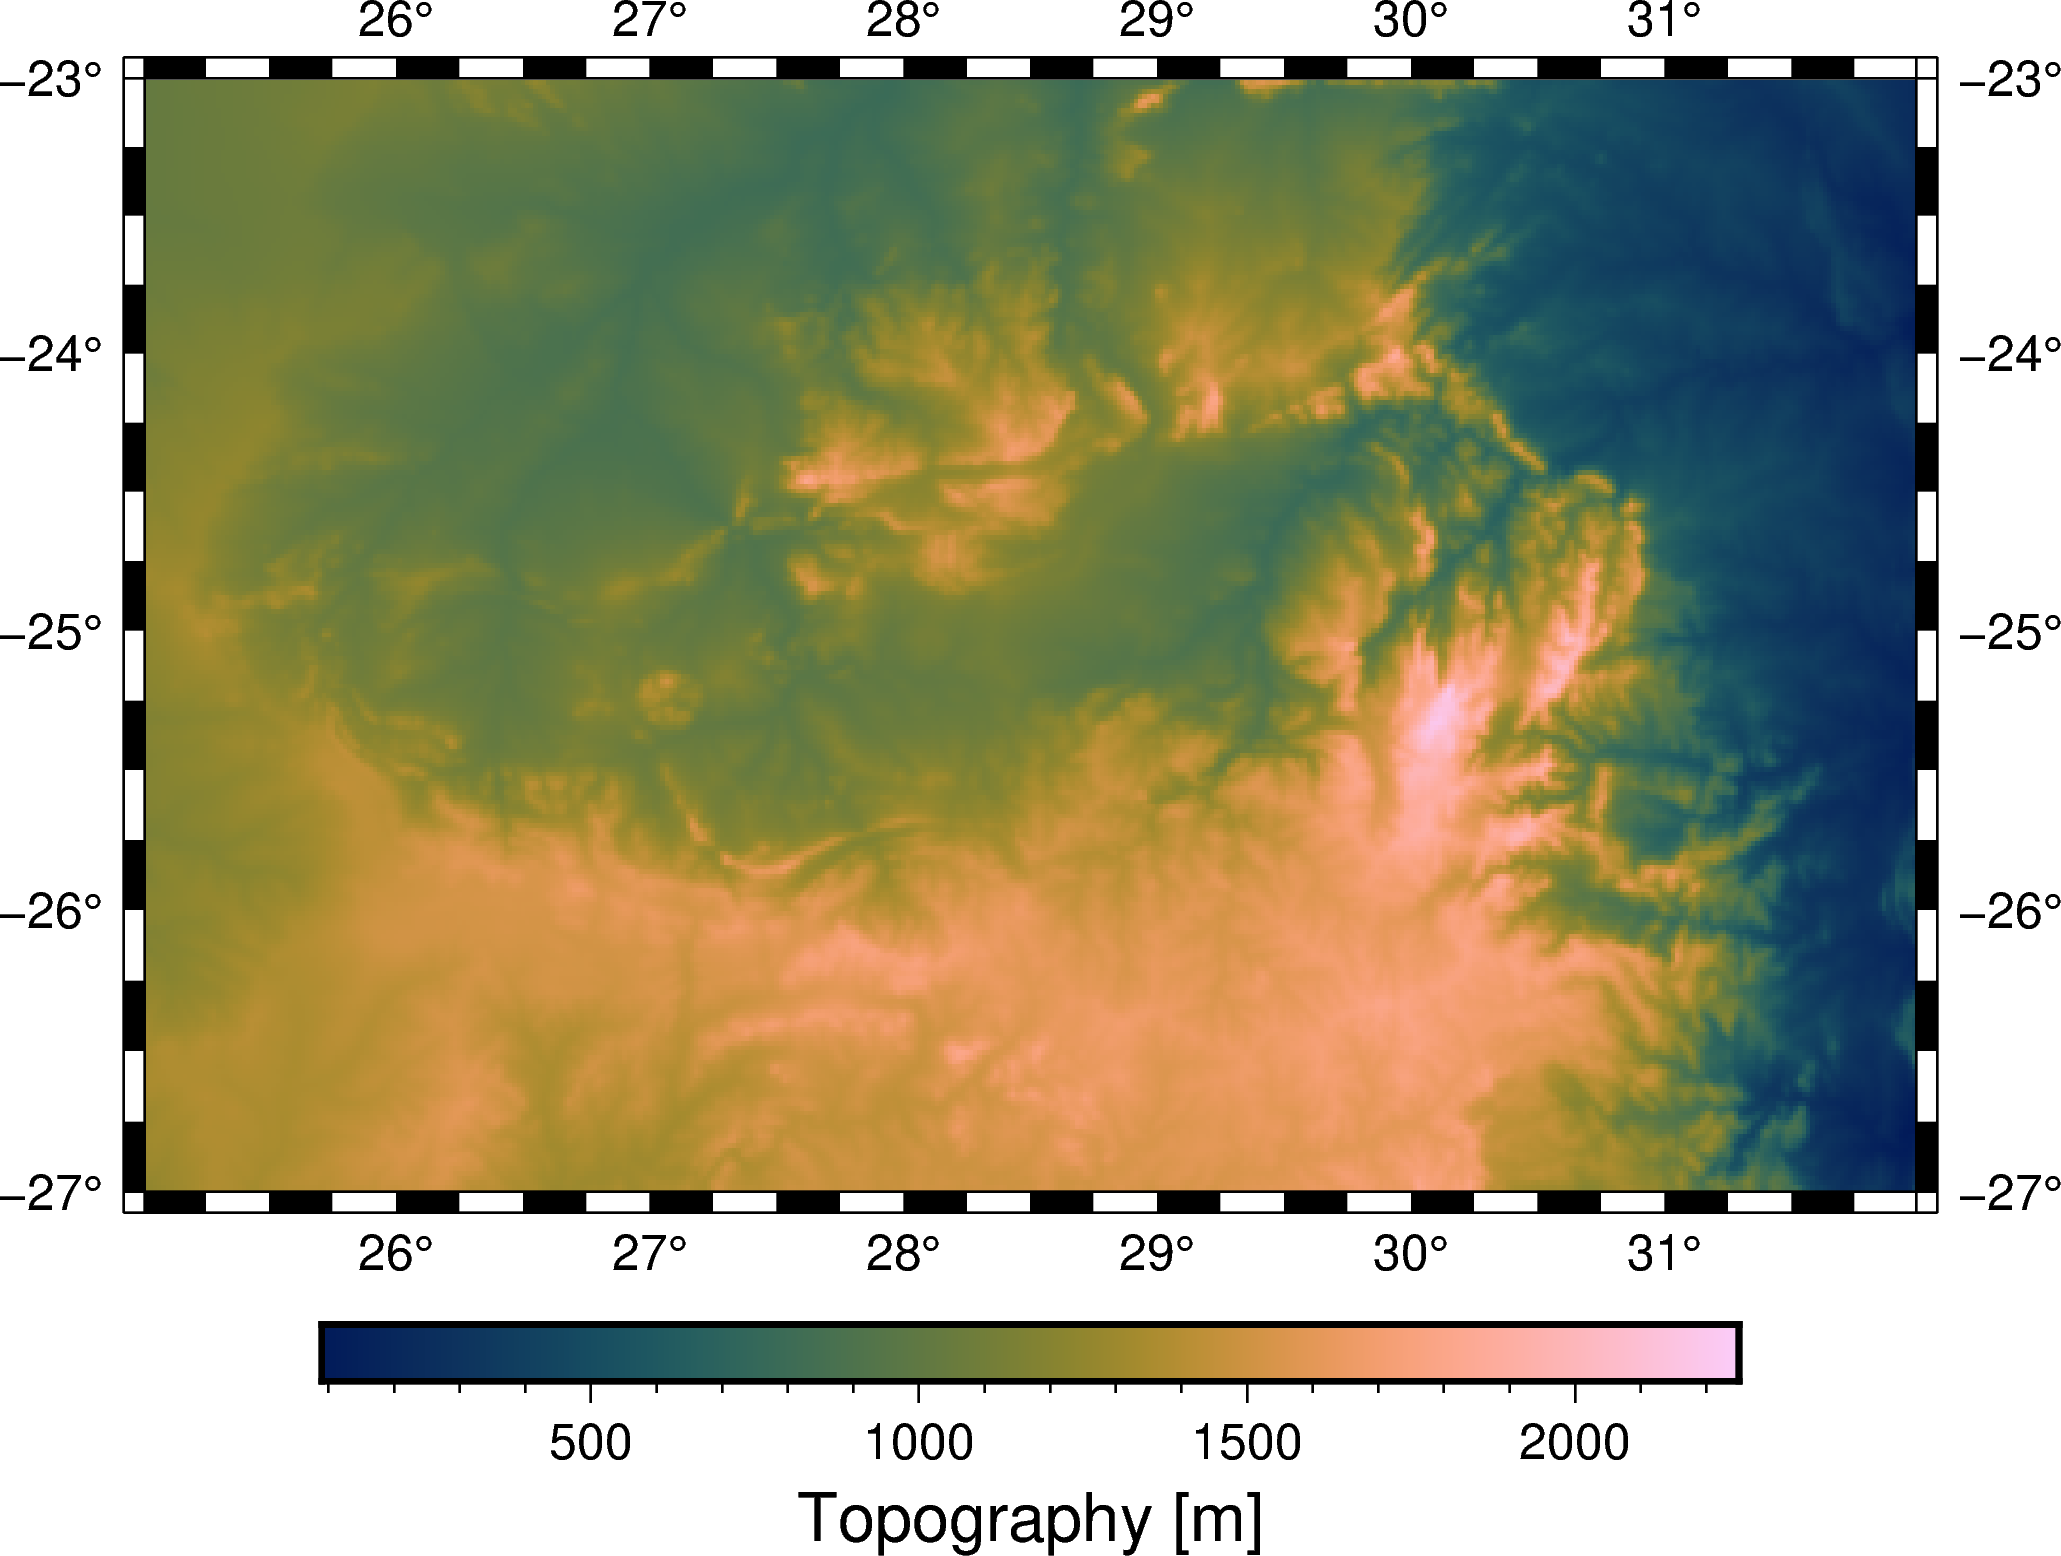

In [10]:
# Plot topography using pygmt:
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

vmin, vmax = topography.values.min(), topography.values.max()
pygmt.makecpt(cmap="batlow", series=[vmin, vmax])
fig.grdimage(topography, projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Topography [m]"')
fig.show()

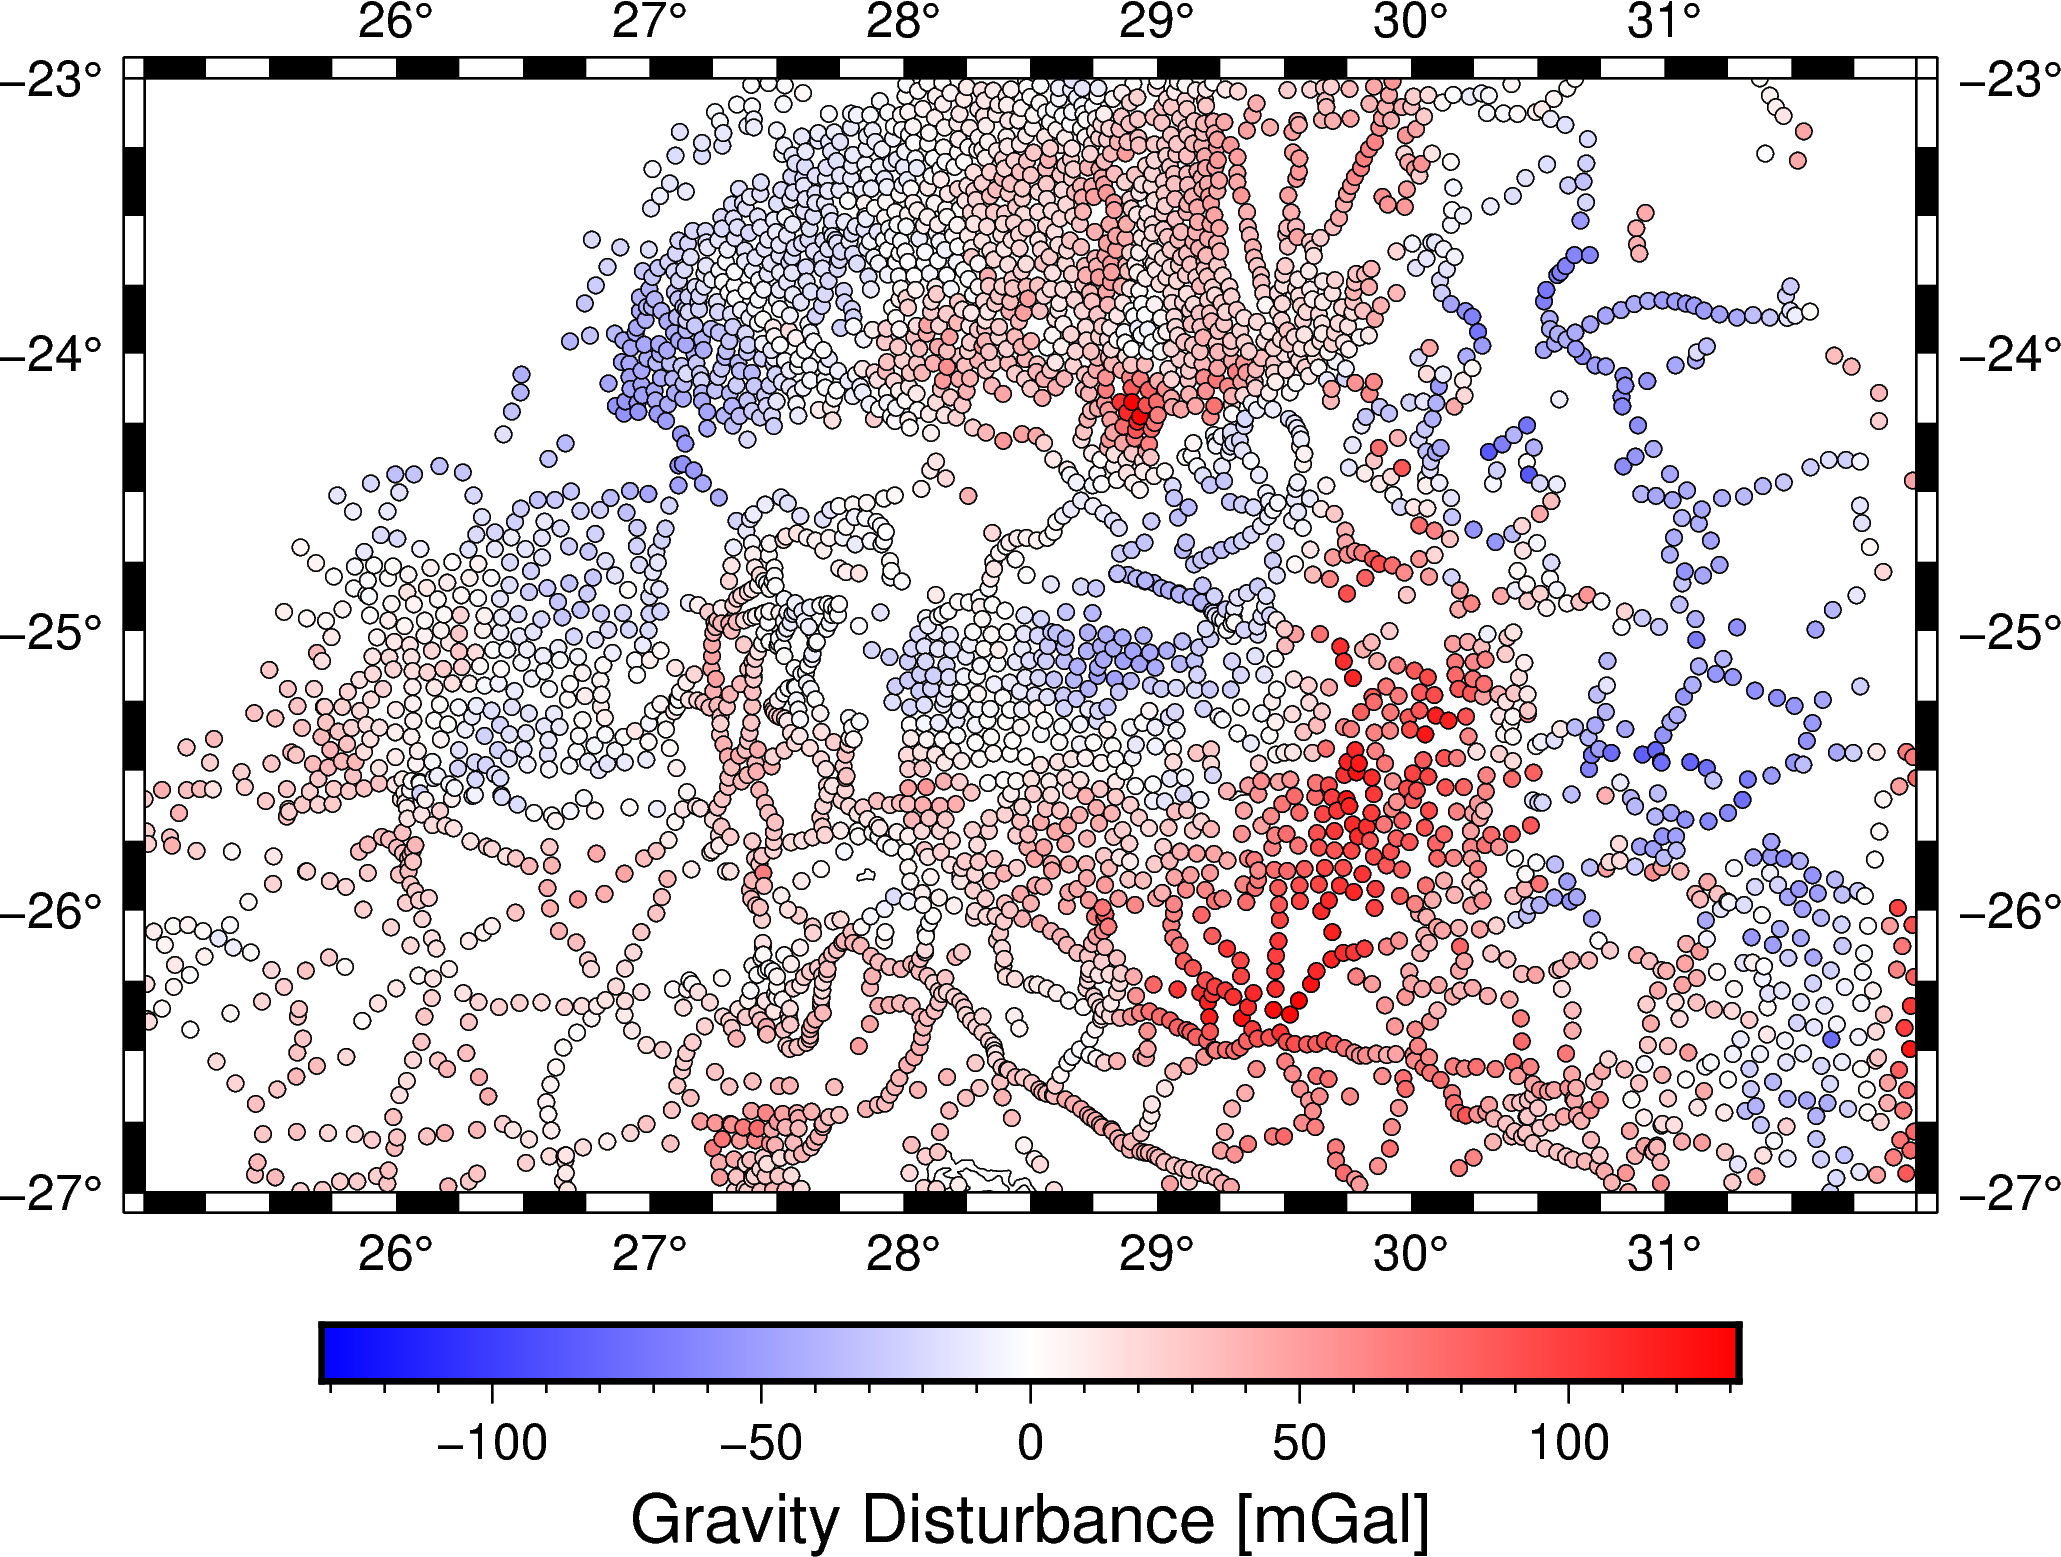

In [11]:
# Plot together gravity disturbance using pygmt

fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

maxabs = vd.maxabs(data.gravity_disturbance)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(x=data.longitude, y=data.latitude, color=data.gravity_disturbance, cmap=True, style="c4p", pen="black", projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Gravity Disturbance [mGal]"')
fig.show()

### Project data to plain coordinates

We will use **[pyproj](https://pypi.org/project/pyproj/)** to project as Cartesian coordinates.

In [12]:
# Set up the projection: 
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
# Project the dataset coordinates:
easting, northing = projection(data.longitude.values, data.latitude.values)

# Add these projected coordinates in the dataset as columns:
data = data.assign(easting=easting)
data = data.assign(northing=northing)
data

latitude  longitude  elevation    gravity  gravity_disturbance  \
8848  -26.26334   25.01500    1230.16  978681.38            16.654699   
8849  -26.38713   25.01932    1297.00  978669.02            16.031458   
8850  -26.39667   25.02499    1304.84  978669.28            18.024250   
8851  -26.07668   25.04500    1165.24  978681.08             9.665660   
8852  -26.35001   25.07668    1262.47  978665.19             4.215785   
...         ...        ...        ...        ...                  ...   
13174 -23.86333   31.51500     300.53  978776.85            -8.543559   
13175 -23.30000   31.52499     280.72  978798.55            44.319034   
13176 -23.19333   31.54832     245.67  978803.55            45.481540   
13177 -23.84833   31.57333     226.77  978808.44             1.280373   
13757 -23.00000   31.37500     285.59  978734.77             1.613859   

            easting      northing  
8848   2.526066e+06 -2.733052e+06  
8849   2.526503e+06 -2.746924e+06  
8850   2.527075e+06 -2.747994e+06  
8851   2.529096e+06 -2.712163e+06  
8852   2.532295e+06 -2.742763e+06  
...             ...           ...  
13174  3.182450e+06 -2.466945e+06  
13175  3.183459e+06 -2.405224e+06  
13176  3.185814e+06 -2.393567e+06  
13177  3.188340e+06 -2.465298e+06  
13757  3.168312e+06 -2.372463e+06  

[3877 rows x 7 columns]

In [13]:
# Project the topography coordinates as a new DataArray:
topo_plain = vd.project_grid(topography, projection=projection)
topo_plain

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.        , 1260.        , 1266.        , ...,  195.        ,
         201.        ,  425.        ],
       [1245.19963571, 1254.09981785, 1261.08318154, ...,  205.8170006 ,
         214.76709168,  375.83181545],
       [1255.63559308, 1257.86748839, 1267.76810468, ...,  200.19876741,
         231.43682566,  302.48459266],
       ...,
       [1029.03190101, 1031.        , 1033.03190101, ...,  248.06380202,
         242.03190101,  238.03190101],
       [1028.67199134, 1030.67199134, 1032.67199134, ...,  247.34398268,
         241.67199134,  237.67199134],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

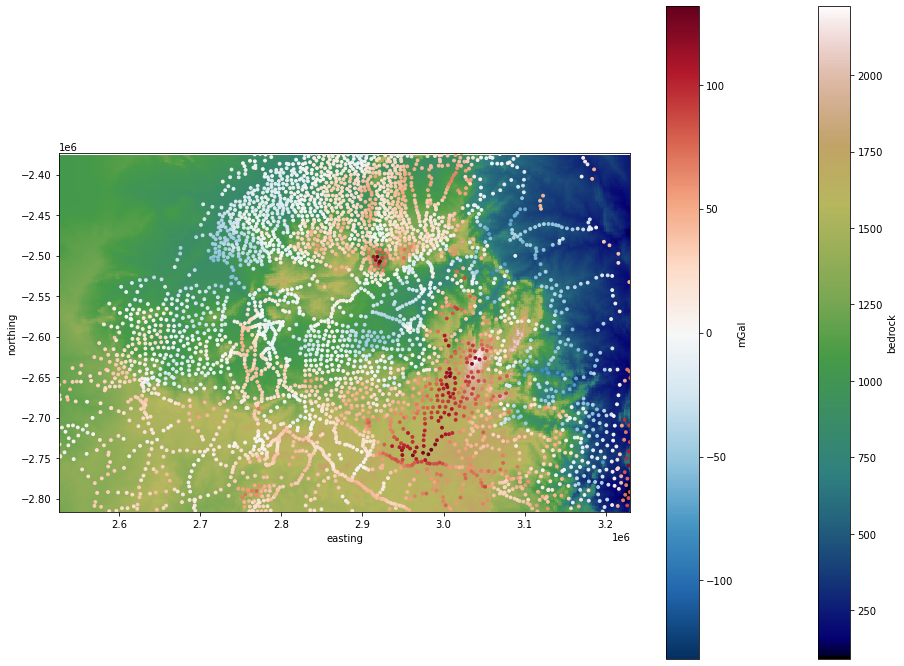

In [14]:
# Plot topo_plain and the gravity_disturbance using matplotlib:
topo_plain.plot(cmap="gist_earth")
maxabs = vd.maxabs(data.gravity_disturbance)
tmp = plt.scatter(data.easting, data.northing, c=data.gravity_disturbance, s=8, cmap="RdBu_r", vmin=-maxabs, vmax=maxabs)
plt.gca().set_aspect("equal")
plt.gcf().set_size_inches(16, 12)
plt.colorbar(tmp, label="mGal")
plt.show()

### Model topography with prisms
<img src="img/prisms.svg">

In [15]:
# Create the prisms xarray.Dataset from the topography:
prisms_centers = (topo_plain.easting, topo_plain.northing)
surface = topo_plain.values
density = 2670 * np.ones_like(surface) # assign density values to the prisms 

topo_prisms = hm.prism_layer(
    prisms_centers,
    surface=surface,
    reference=0,
    properties={"density": density}
)
topo_prisms

<xarray.Dataset>
Dimensions:   (easting: 419, northing: 240)
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
    top       (northing, easting) float64 1.257e+03 1.26e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

### Compute the gravitational effect of the layer of prisms

In [16]:
# Define the coordinates where we are going to calculate the gravity effect of the prisms
coordinates = (data.easting, data.northing, data.elevation)

# Use the "prism_layer" accessor to compute gravity field of the layer
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

### Compute the Bouguer gravity disturbance

In [17]:
bouguer_disturbance = data.gravity_disturbance - result
# Add the bouguer_disturbance to the dataset as a column 
data = data.assign(bouguer_disturbance=bouguer_disturbance)

data

latitude  longitude  elevation    gravity  gravity_disturbance  \
8848  -26.26334   25.01500    1230.16  978681.38            16.654699   
8849  -26.38713   25.01932    1297.00  978669.02            16.031458   
8850  -26.39667   25.02499    1304.84  978669.28            18.024250   
8851  -26.07668   25.04500    1165.24  978681.08             9.665660   
8852  -26.35001   25.07668    1262.47  978665.19             4.215785   
...         ...        ...        ...        ...                  ...   
13174 -23.86333   31.51500     300.53  978776.85            -8.543559   
13175 -23.30000   31.52499     280.72  978798.55            44.319034   
13176 -23.19333   31.54832     245.67  978803.55            45.481540   
13177 -23.84833   31.57333     226.77  978808.44             1.280373   
13757 -23.00000   31.37500     285.59  978734.77             1.613859   

            easting      northing  bouguer_disturbance  
8848   2.526066e+06 -2.733052e+06           -89.537848  
8849   2.526503e+06 -2.746924e+06          -104.667622  
8850   2.527075e+06 -2.747994e+06          -110.810297  
8851   2.529096e+06 -2.712163e+06          -112.746186  
8852   2.532295e+06 -2.742763e+06          -132.438823  
...             ...           ...                  ...  
13174  3.182450e+06 -2.466945e+06           -41.414814  
13175  3.183459e+06 -2.405224e+06            14.553012  
13176  3.185814e+06 -2.393567e+06            21.348479  
13177  3.188340e+06 -2.465298e+06           -22.305804  
13757  3.168312e+06 -2.372463e+06             1.166559  

[3877 rows x 8 columns]

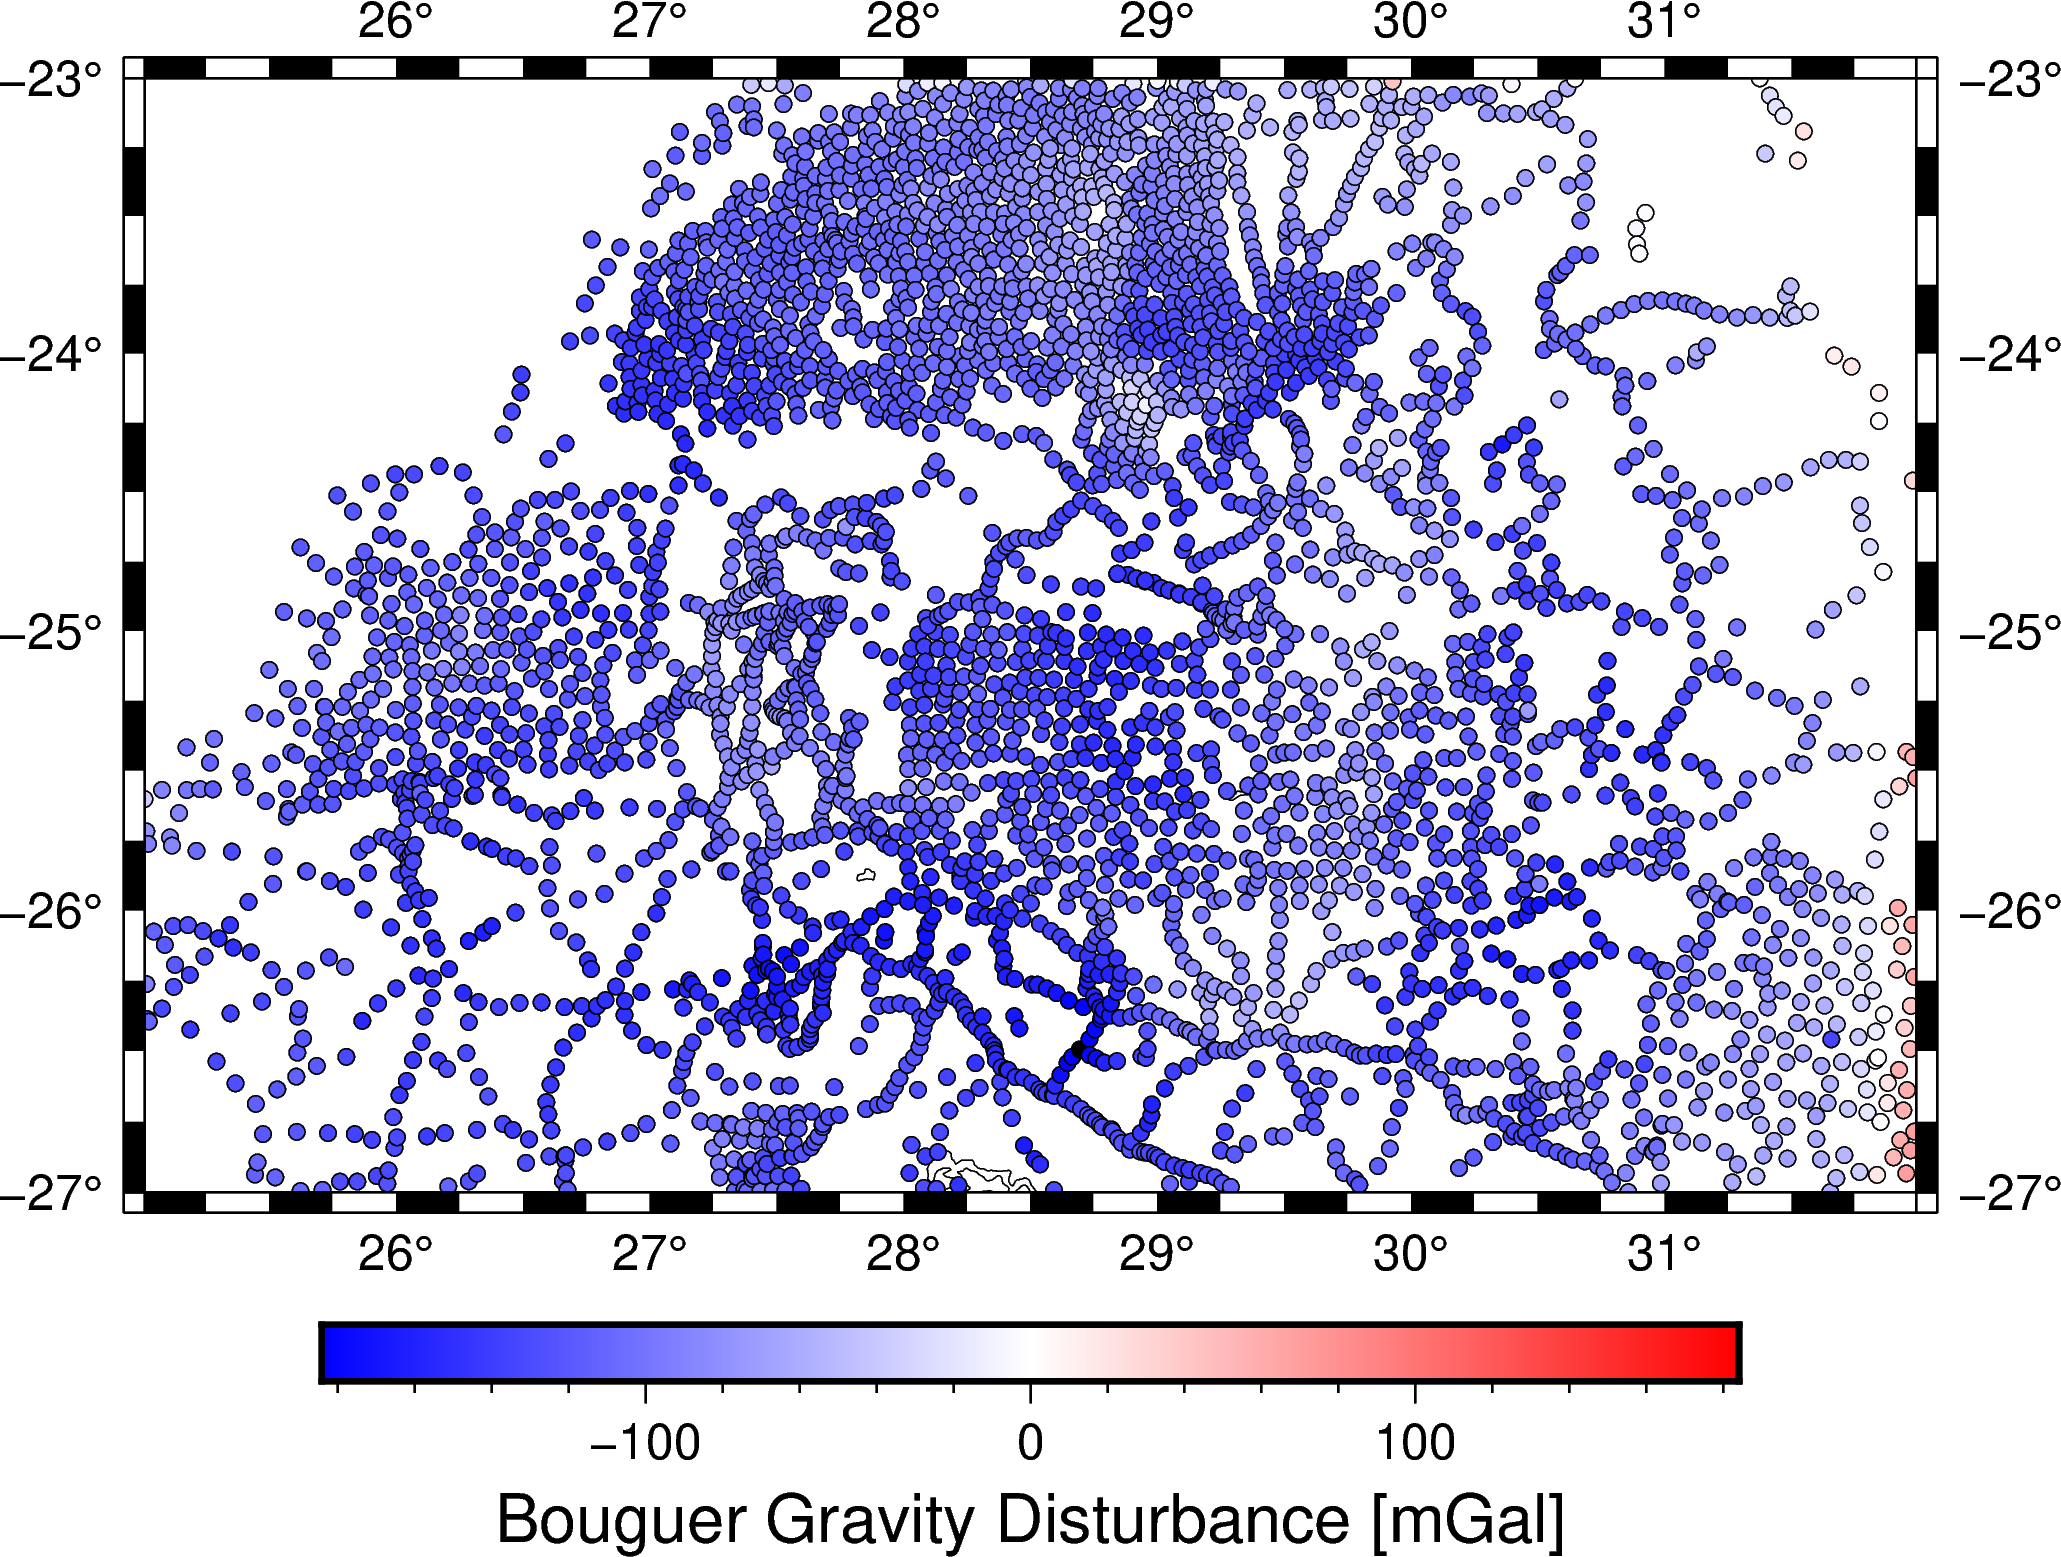

In [18]:
# Plot the Bouguer disturbance using pygmt
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

maxabs = vd.maxabs(data.bouguer_disturbance)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(x=data.longitude, y=data.latitude, color=data.bouguer_disturbance, cmap=True, style="c4p", pen="black", projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Bouguer Gravity Disturbance [mGal]"')
fig.show()

## Compute residuals: remove regional trend

A common processing step is the removal of 2D polyomial trends from the data. 
This often helps interpolation methods which can struggle to recover the long wavelengths of data.

To compute the residual, we will use [Verde](https://www.fatiando.org/verde).

In [19]:
# Compute the trend from the Bouguer disturbance using a second-order polynomial:
trend = vd.Trend(degree=2)
trend.fit(coordinates, data.bouguer_disturbance)

# Remove the trend from the Bouguer disturbance:
residuals = data.bouguer_disturbance - trend.predict(coordinates)

In [20]:
# Add the residual to the dataset as a column: 
data = data.assign(bouguer_residuals=residuals)
data

latitude  longitude  elevation    gravity  gravity_disturbance  \
8848  -26.26334   25.01500    1230.16  978681.38            16.654699   
8849  -26.38713   25.01932    1297.00  978669.02            16.031458   
8850  -26.39667   25.02499    1304.84  978669.28            18.024250   
8851  -26.07668   25.04500    1165.24  978681.08             9.665660   
8852  -26.35001   25.07668    1262.47  978665.19             4.215785   
...         ...        ...        ...        ...                  ...   
13174 -23.86333   31.51500     300.53  978776.85            -8.543559   
13175 -23.30000   31.52499     280.72  978798.55            44.319034   
13176 -23.19333   31.54832     245.67  978803.55            45.481540   
13177 -23.84833   31.57333     226.77  978808.44             1.280373   
13757 -23.00000   31.37500     285.59  978734.77             1.613859   

            easting      northing  bouguer_disturbance  bouguer_residuals  
8848   2.526066e+06 -2.733052e+06           -89.537848          20.664808  
8849   2.526503e+06 -2.746924e+06          -104.667622           5.367781  
8850   2.527075e+06 -2.747994e+06          -110.810297          -0.690107  
8851   2.529096e+06 -2.712163e+06          -112.746186          -1.928538  
8852   2.532295e+06 -2.742763e+06          -132.438823         -21.178332  
...             ...           ...                  ...                ...  
13174  3.182450e+06 -2.466945e+06           -41.414814          16.012272  
13175  3.183459e+06 -2.405224e+06            14.553012          57.102403  
13176  3.185814e+06 -2.393567e+06            21.348479          60.057467  
13177  3.188340e+06 -2.465298e+06           -22.305804          33.118392  
13757  3.168312e+06 -2.372463e+06             1.166559          38.453275  

[3877 rows x 9 columns]

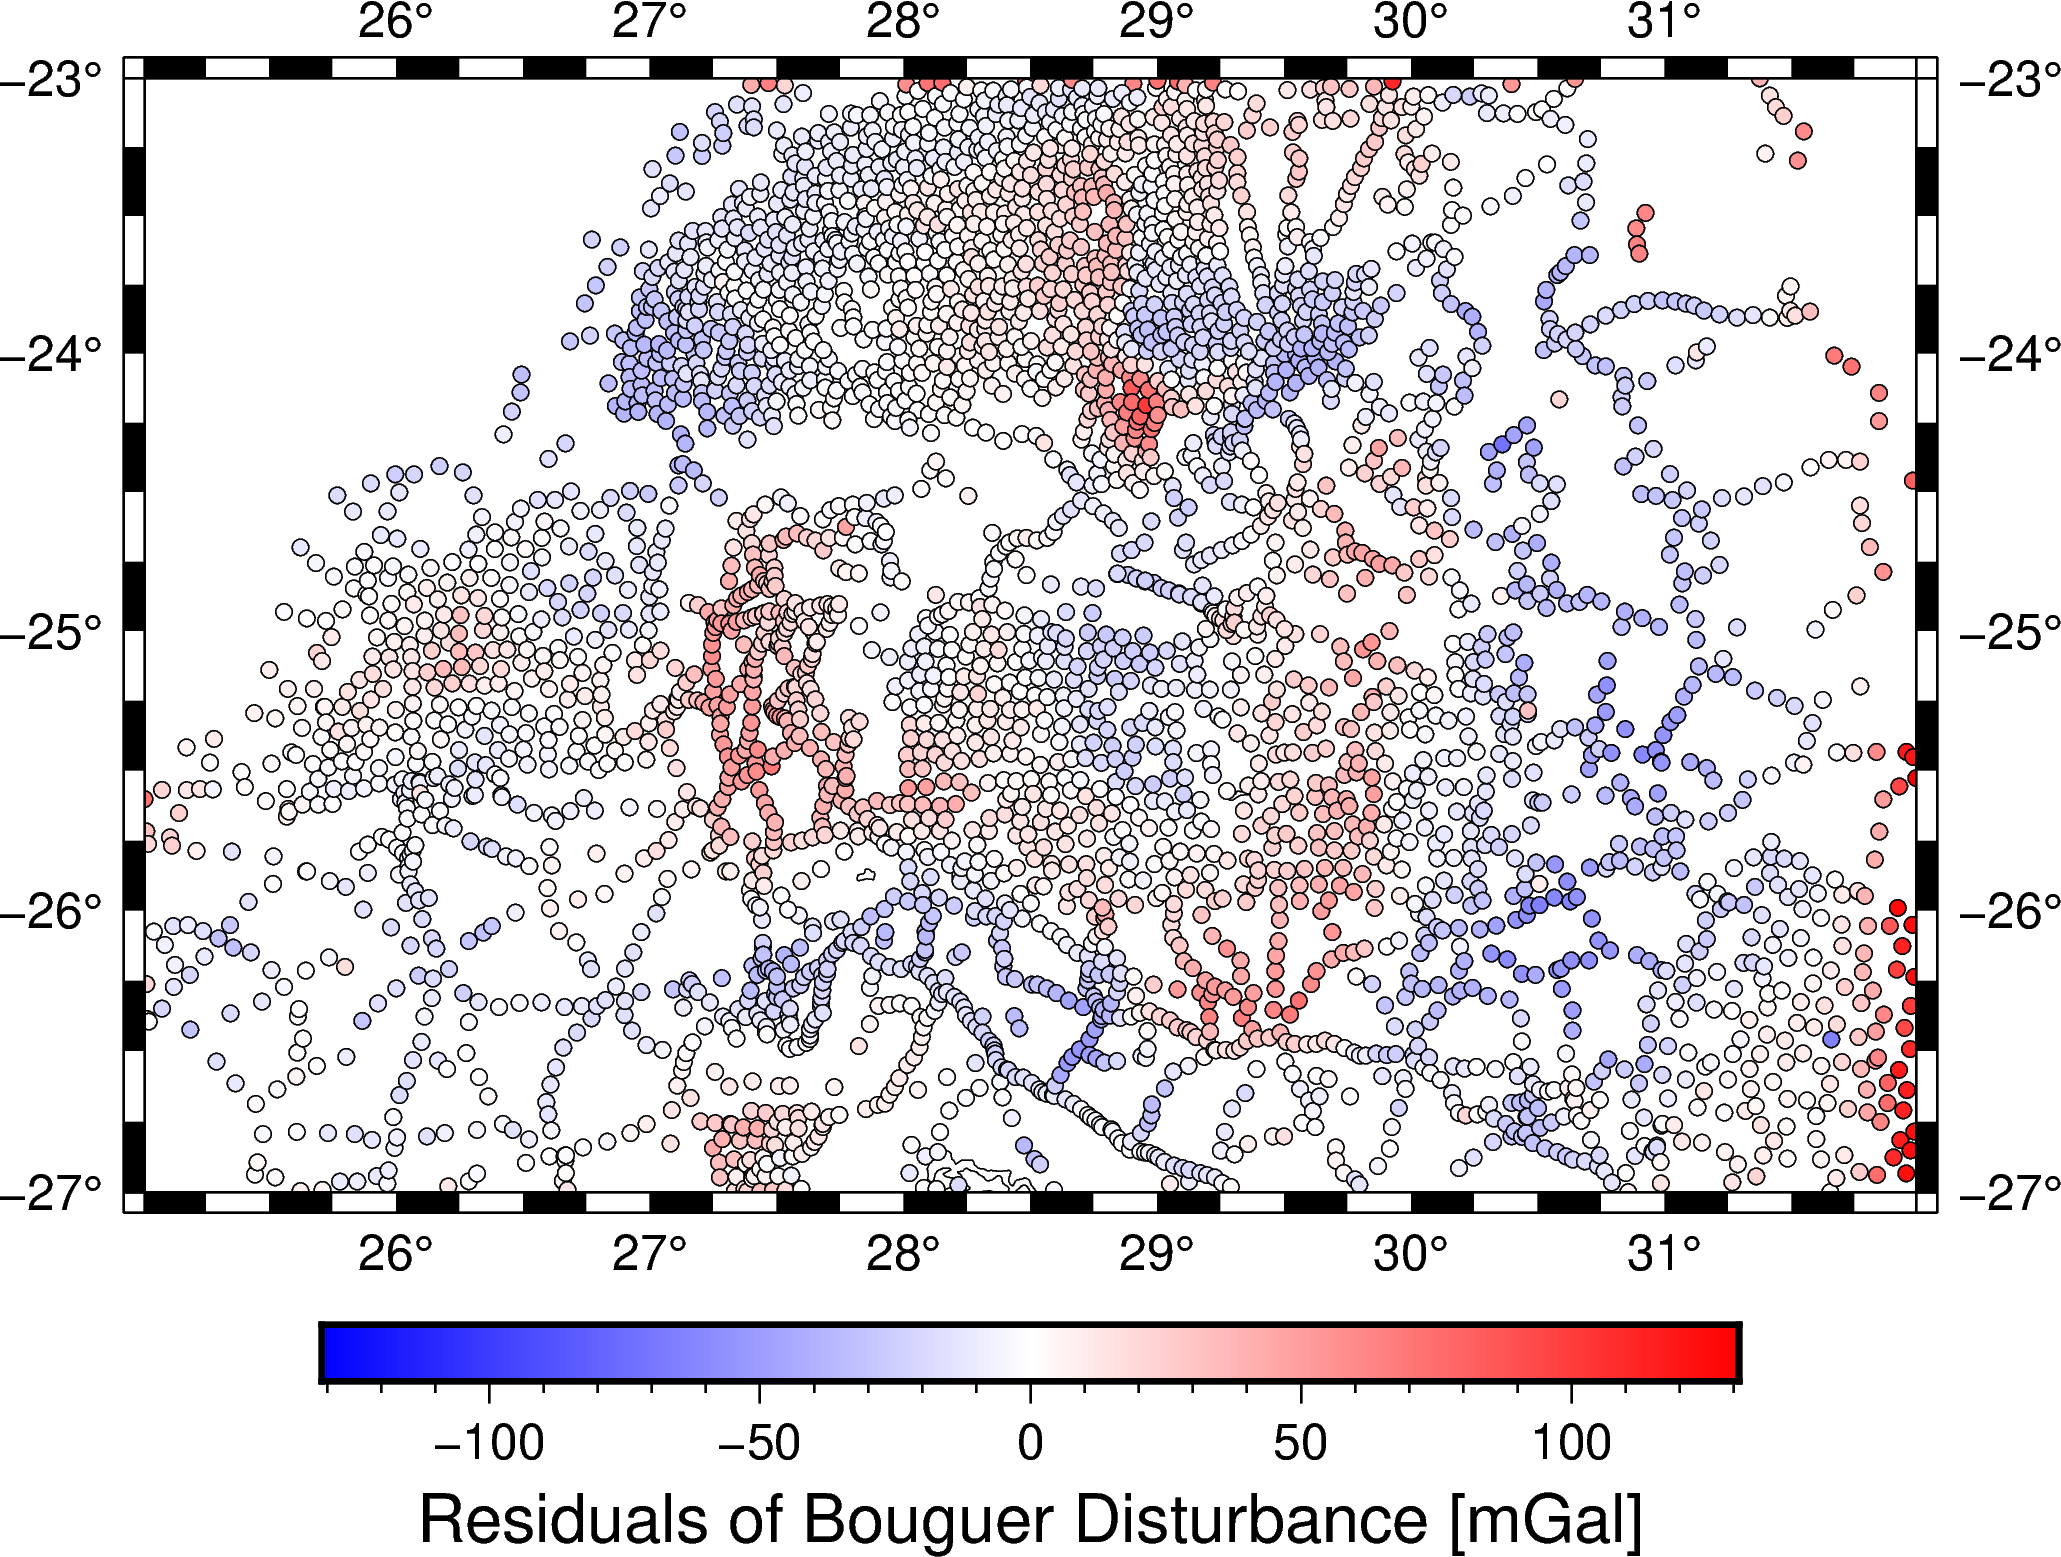

In [21]:
# Plot the resudual using pygmt
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

maxabs = vd.maxabs(data.bouguer_residuals)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(x=data.longitude, y=data.latitude, color=data.bouguer_residuals, cmap=True, style="c4p", pen="black", projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Residuals of Bouguer Disturbance [mGal]"')
fig.show()

## Grid the residuals

To grid the residuals disturbance, we will use the _equivalent layer method_. 
The advantage of using this method is that it takes into account the 3D nature of the observations, not just their horizontal positions. 
It also allows data uncertainty to be taken into account and noise to be suppressed though the least-squares fitting process. 

For this processing we are going to use the [Harmonica](https://www.fatiando.org/harmonica).

<img src="img/eql.svg">

In [22]:
# Create the equivalent layer:
eql = hm.EQLHarmonic(damping=1e2, relative_depth=5e3)  # The damping parameter helps smooth the predicted data and ensure stability.

# Fit the layer coefficients to the observed residual disturbance:
eql.fit(coordinates, data.bouguer_residuals)

EQLHarmonic(damping=100.0, relative_depth=5000.0)

In [23]:
data.elevation.max()

2144.0

In [24]:
# Interpolate data onto a regular grid:
grid = eql.grid(
    upward=2200, #we are setting the layer a little over the max elevation
    region=region_deg,
    spacing=0.01,
    data_names=["bouguer_residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 699)
Coordinates:
  * longitude          (longitude) float64 25.01 25.02 25.03 ... 31.98 31.99
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 -1.23 -1.241 ... 11.58
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100.0, relative_depth=5000.0)

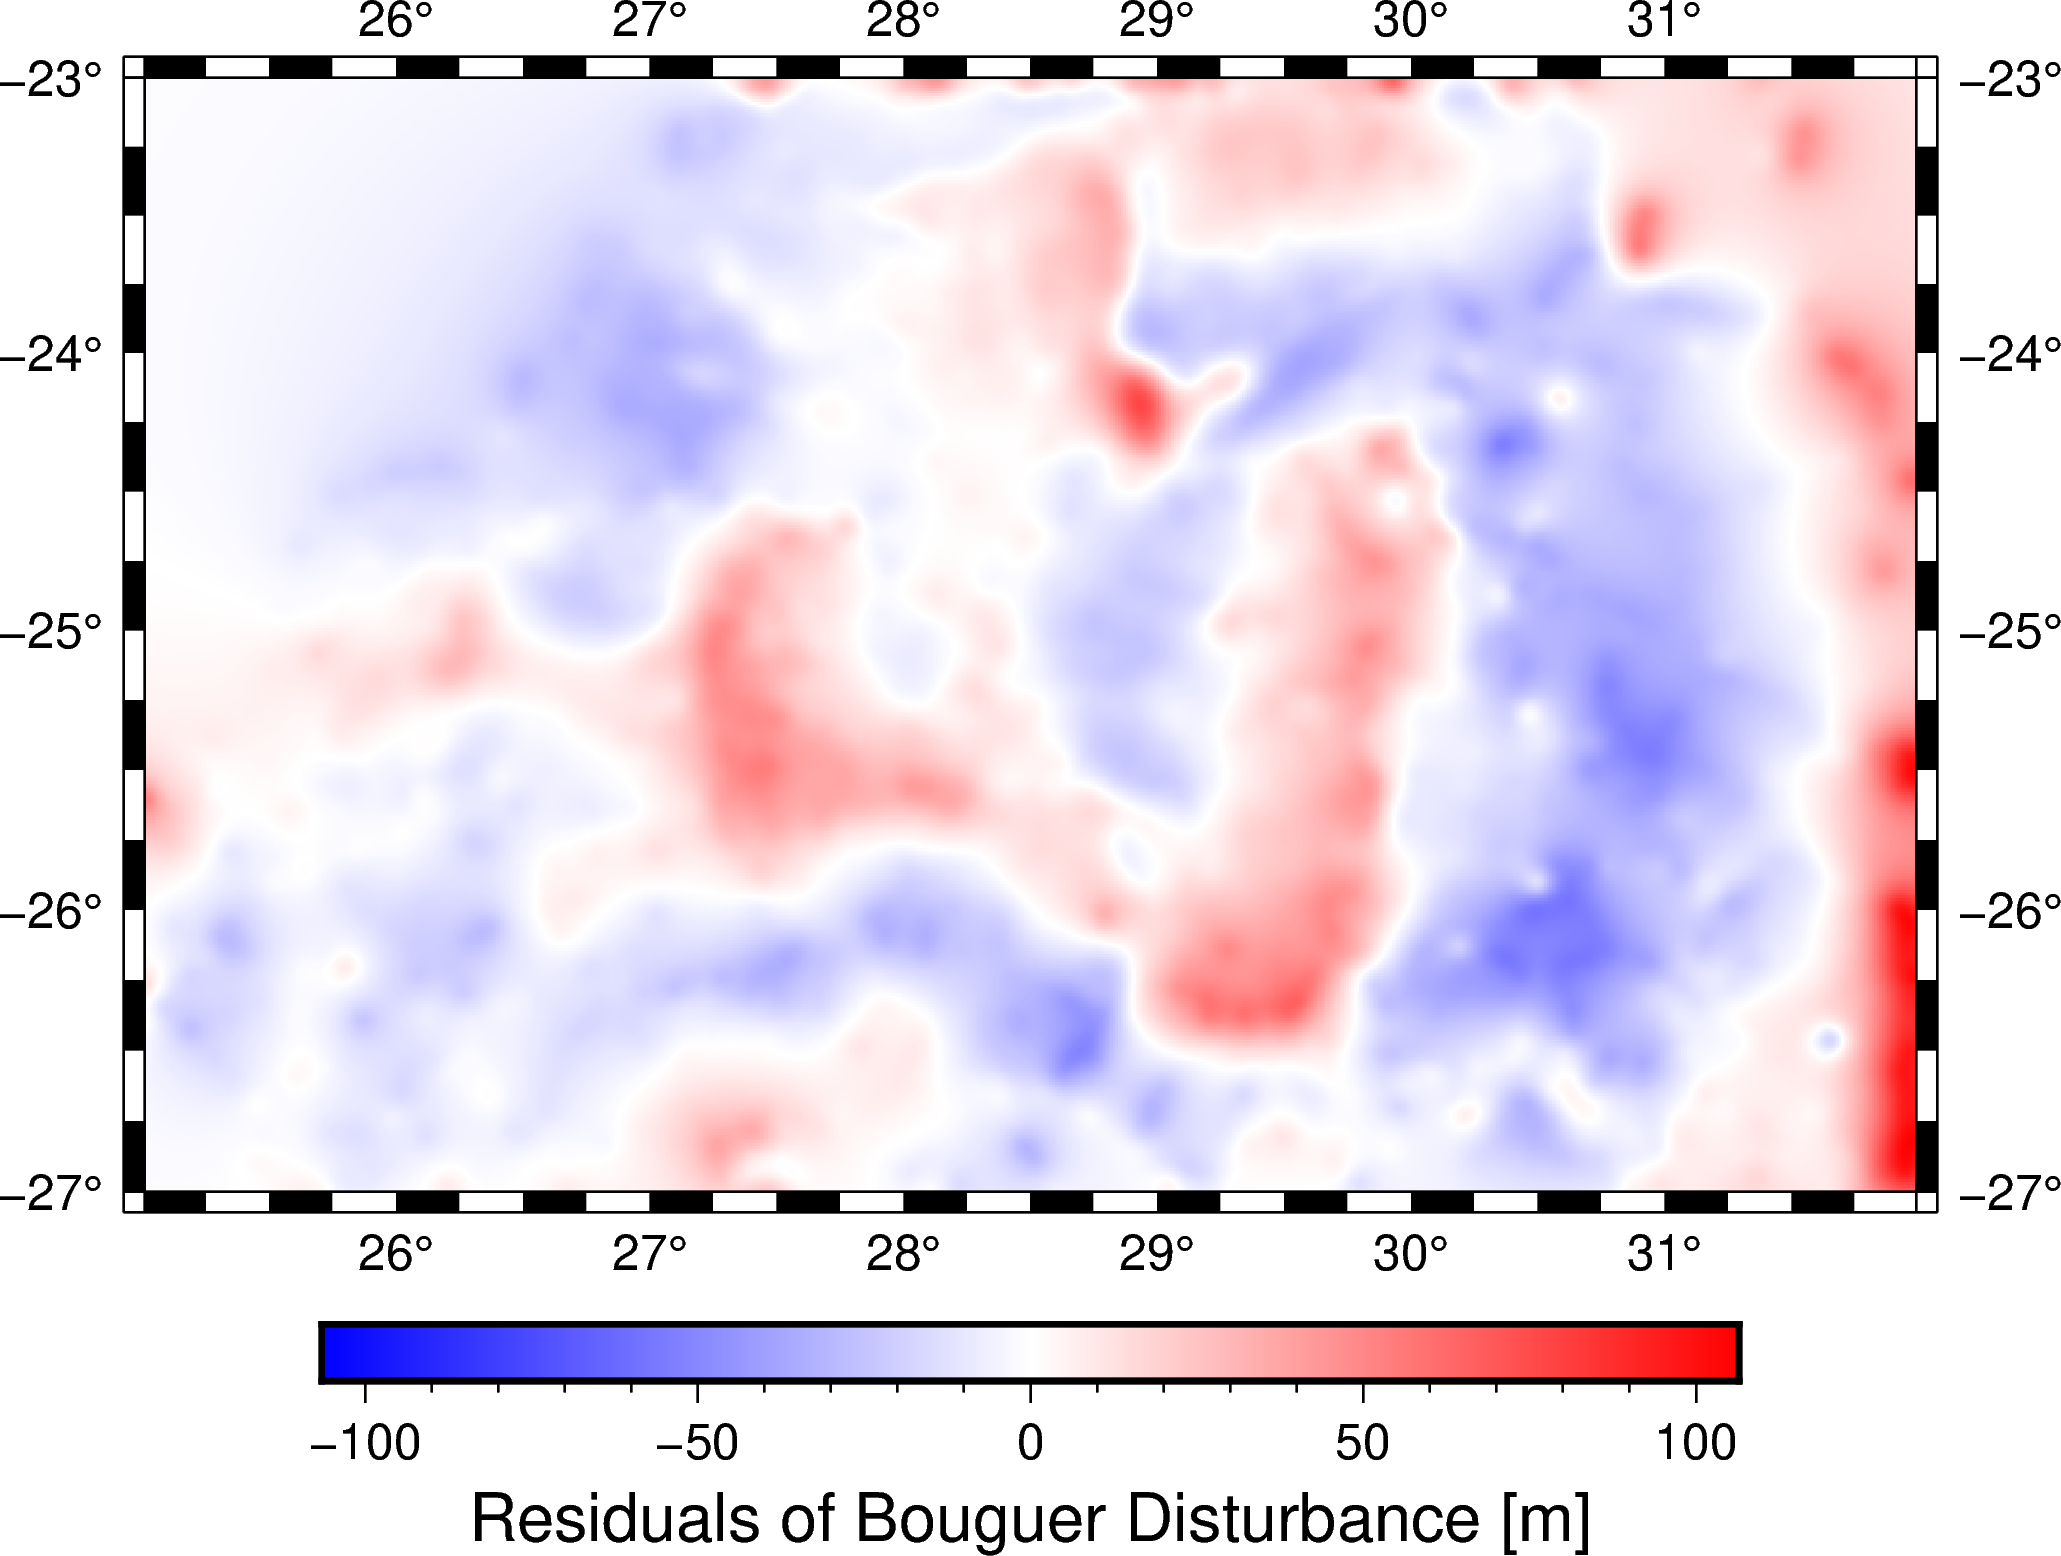

In [25]:
# Plot the gridded residual disturbance using pygmt:
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

maxabs = vd.maxabs(grid.bouguer_residuals)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.grdimage(grid.bouguer_residuals, projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Residuals of Bouguer Disturbance [m]"')
fig.show()

In [26]:
# Mask grid points that are outside the convex hull of the given data points:
grid = vd.convexhull_mask(data_coordinates=(data.longitude, data.latitude), grid=grid)
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 699)
Coordinates:
  * longitude          (longitude) float64 25.01 25.02 25.03 ... 31.98 31.99
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100.0, relative_depth=5000.0)

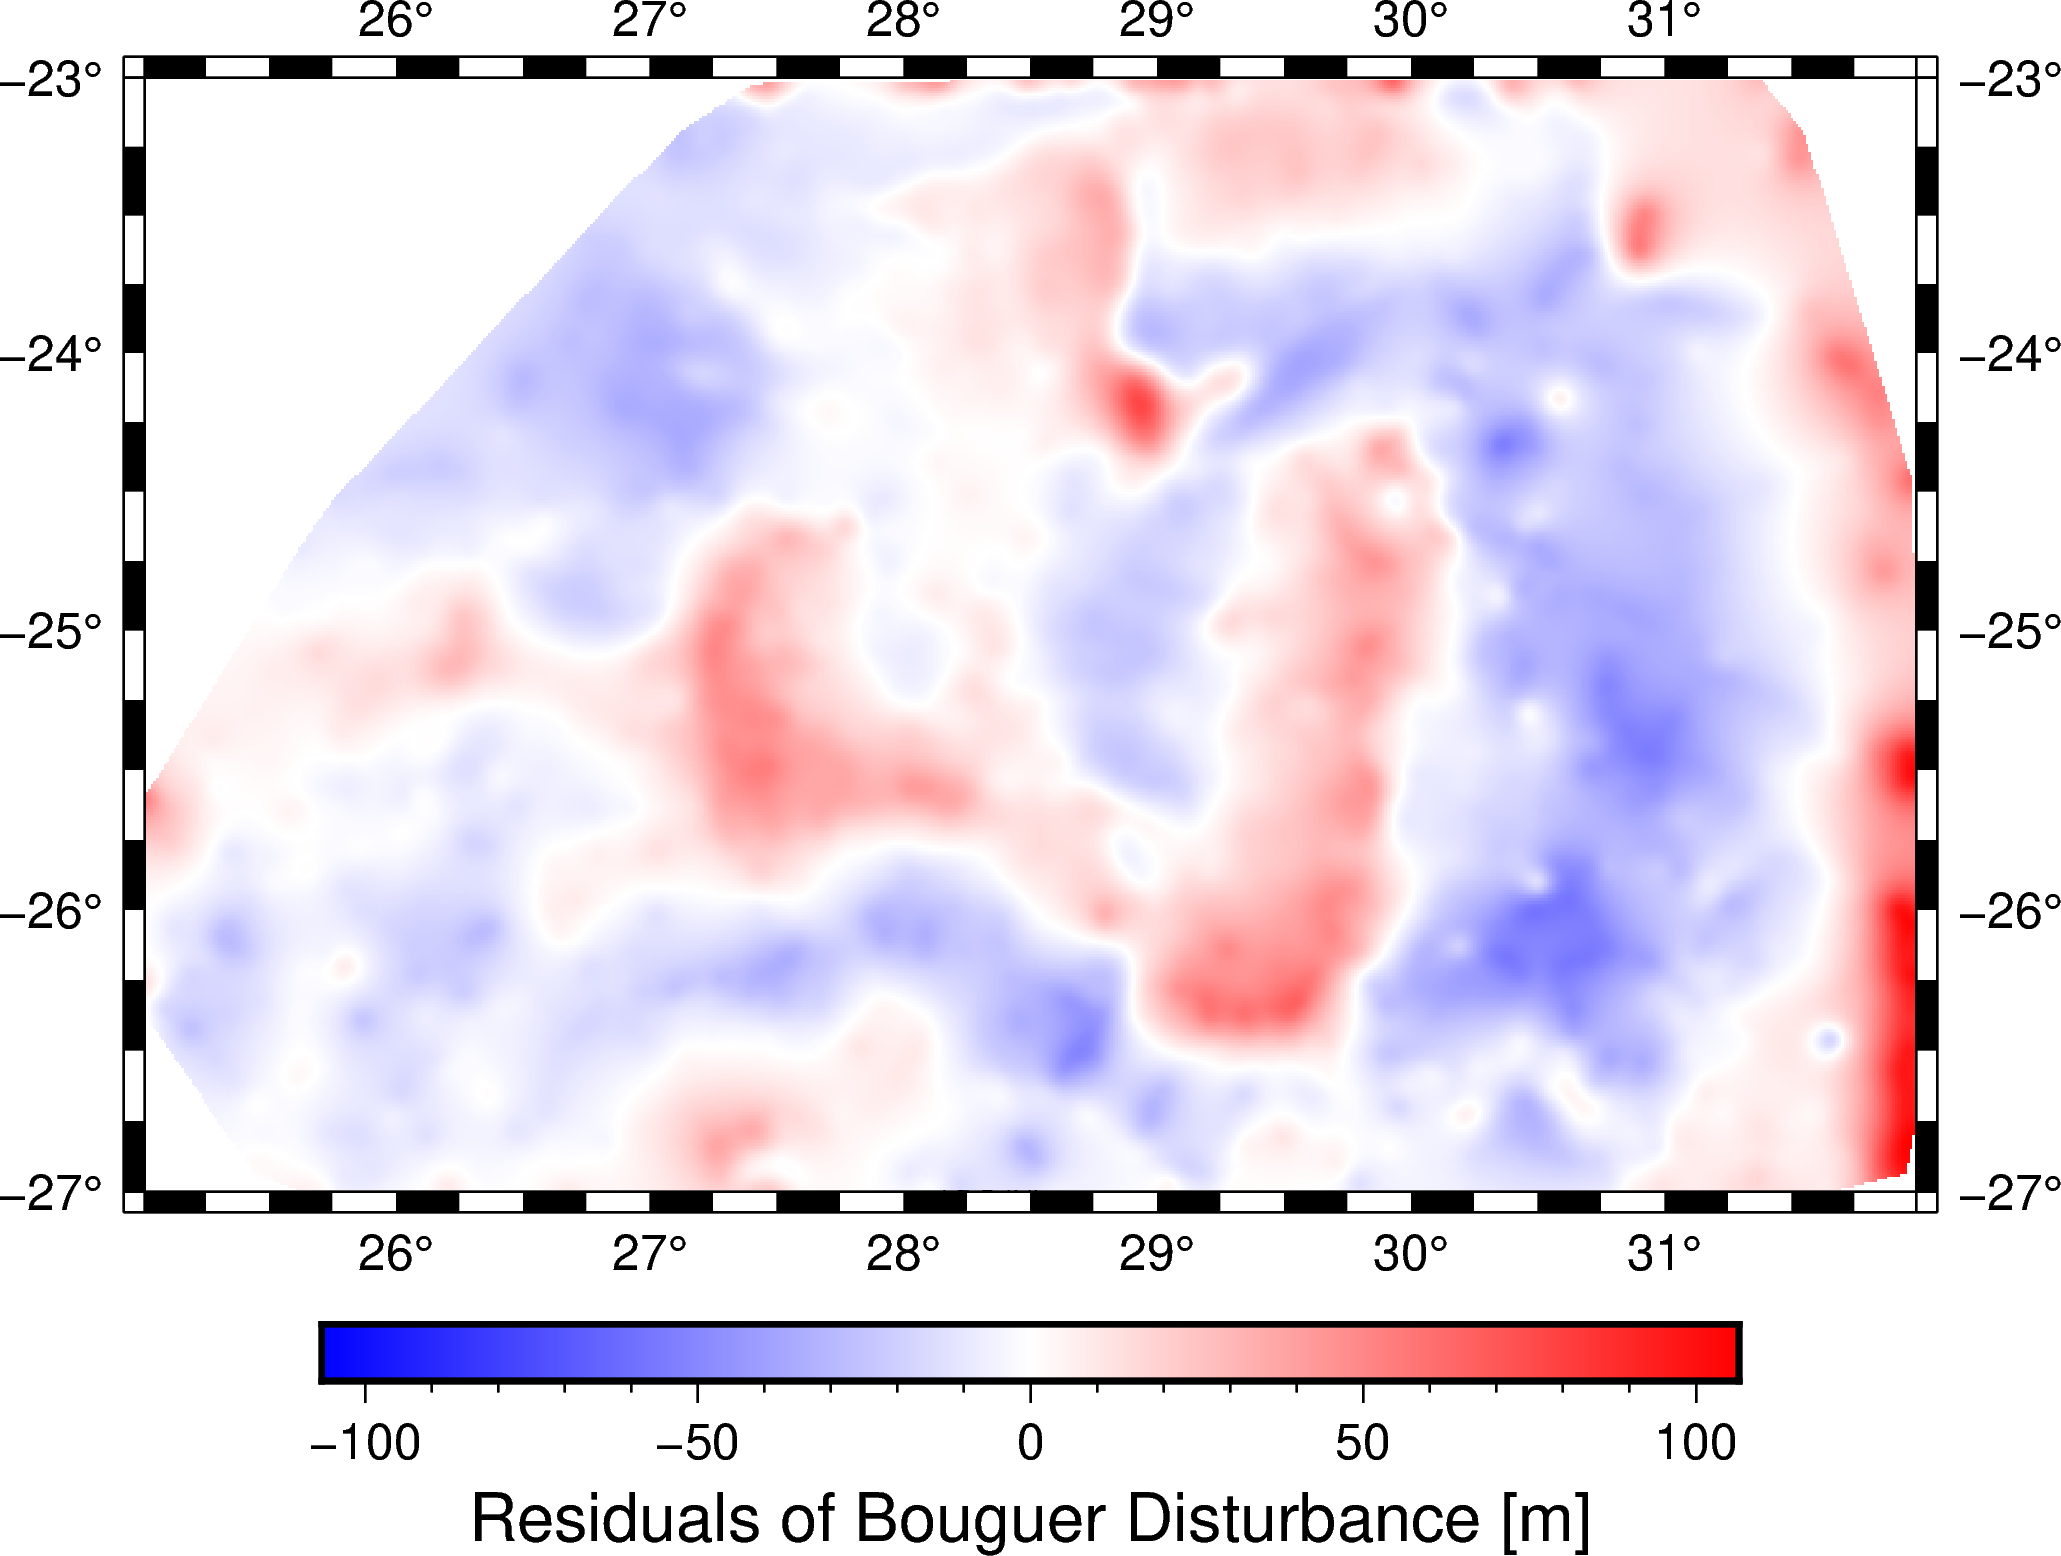

In [27]:
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

maxabs = vd.maxabs(grid.bouguer_residuals)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.grdimage(grid.bouguer_residuals, nan_transparent=True, projection=projection_gmt)
fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Residuals of Bouguer Disturbance [m]"')
fig.show()

<img src="img/study-area.png">

## Extract a profile

We will interpolate the residual disturbance along a profile between two points using equivalent layer.

In [28]:
point1 = (26, -25) #easting , northing 
point2 = (31, -25) 

# Interpolate the data from the equivalent layer generated in section 1.7:
profile = eql.profile(
    point1=point1,
    point2=point2,
    upward=data.elevation.max(),
    size=200,
    data_names=["bouguer_residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)
profile

latitude  longitude       distance  upward  bouguer_residuals
0       -25.0  26.000000       0.000000  2144.0           5.671591
1       -25.0  26.025126    2537.237799  2144.0           6.174695
2       -25.0  26.050251    5074.475598  2144.0           6.726459
3       -25.0  26.075377    7611.713397  2144.0           7.332022
4       -25.0  26.100503   10148.951197  2144.0           8.134406
..        ...        ...            ...     ...                ...
195     -25.0  30.899497  494761.370830  2144.0         -36.373336
196     -25.0  30.924623  497298.608629  2144.0         -36.518812
197     -25.0  30.949749  499835.846428  2144.0         -36.289834
198     -25.0  30.974874  502373.084227  2144.0         -35.748115
199     -25.0  31.000000  504910.322026  2144.0         -34.834729

[200 rows x 5 columns]

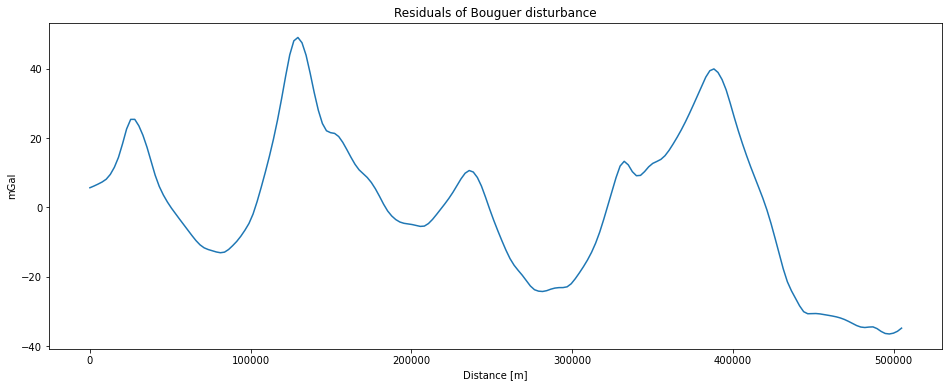

In [29]:
# Plot the profile using mathplotlib:
plt.plot(profile.distance, profile.bouguer_residuals)
plt.ylabel("mGal")
plt.xlabel("Distance [m]")
plt.title("Residuals of Bouguer disturbance")
plt.gcf().set_size_inches(16, 6)
plt.show()

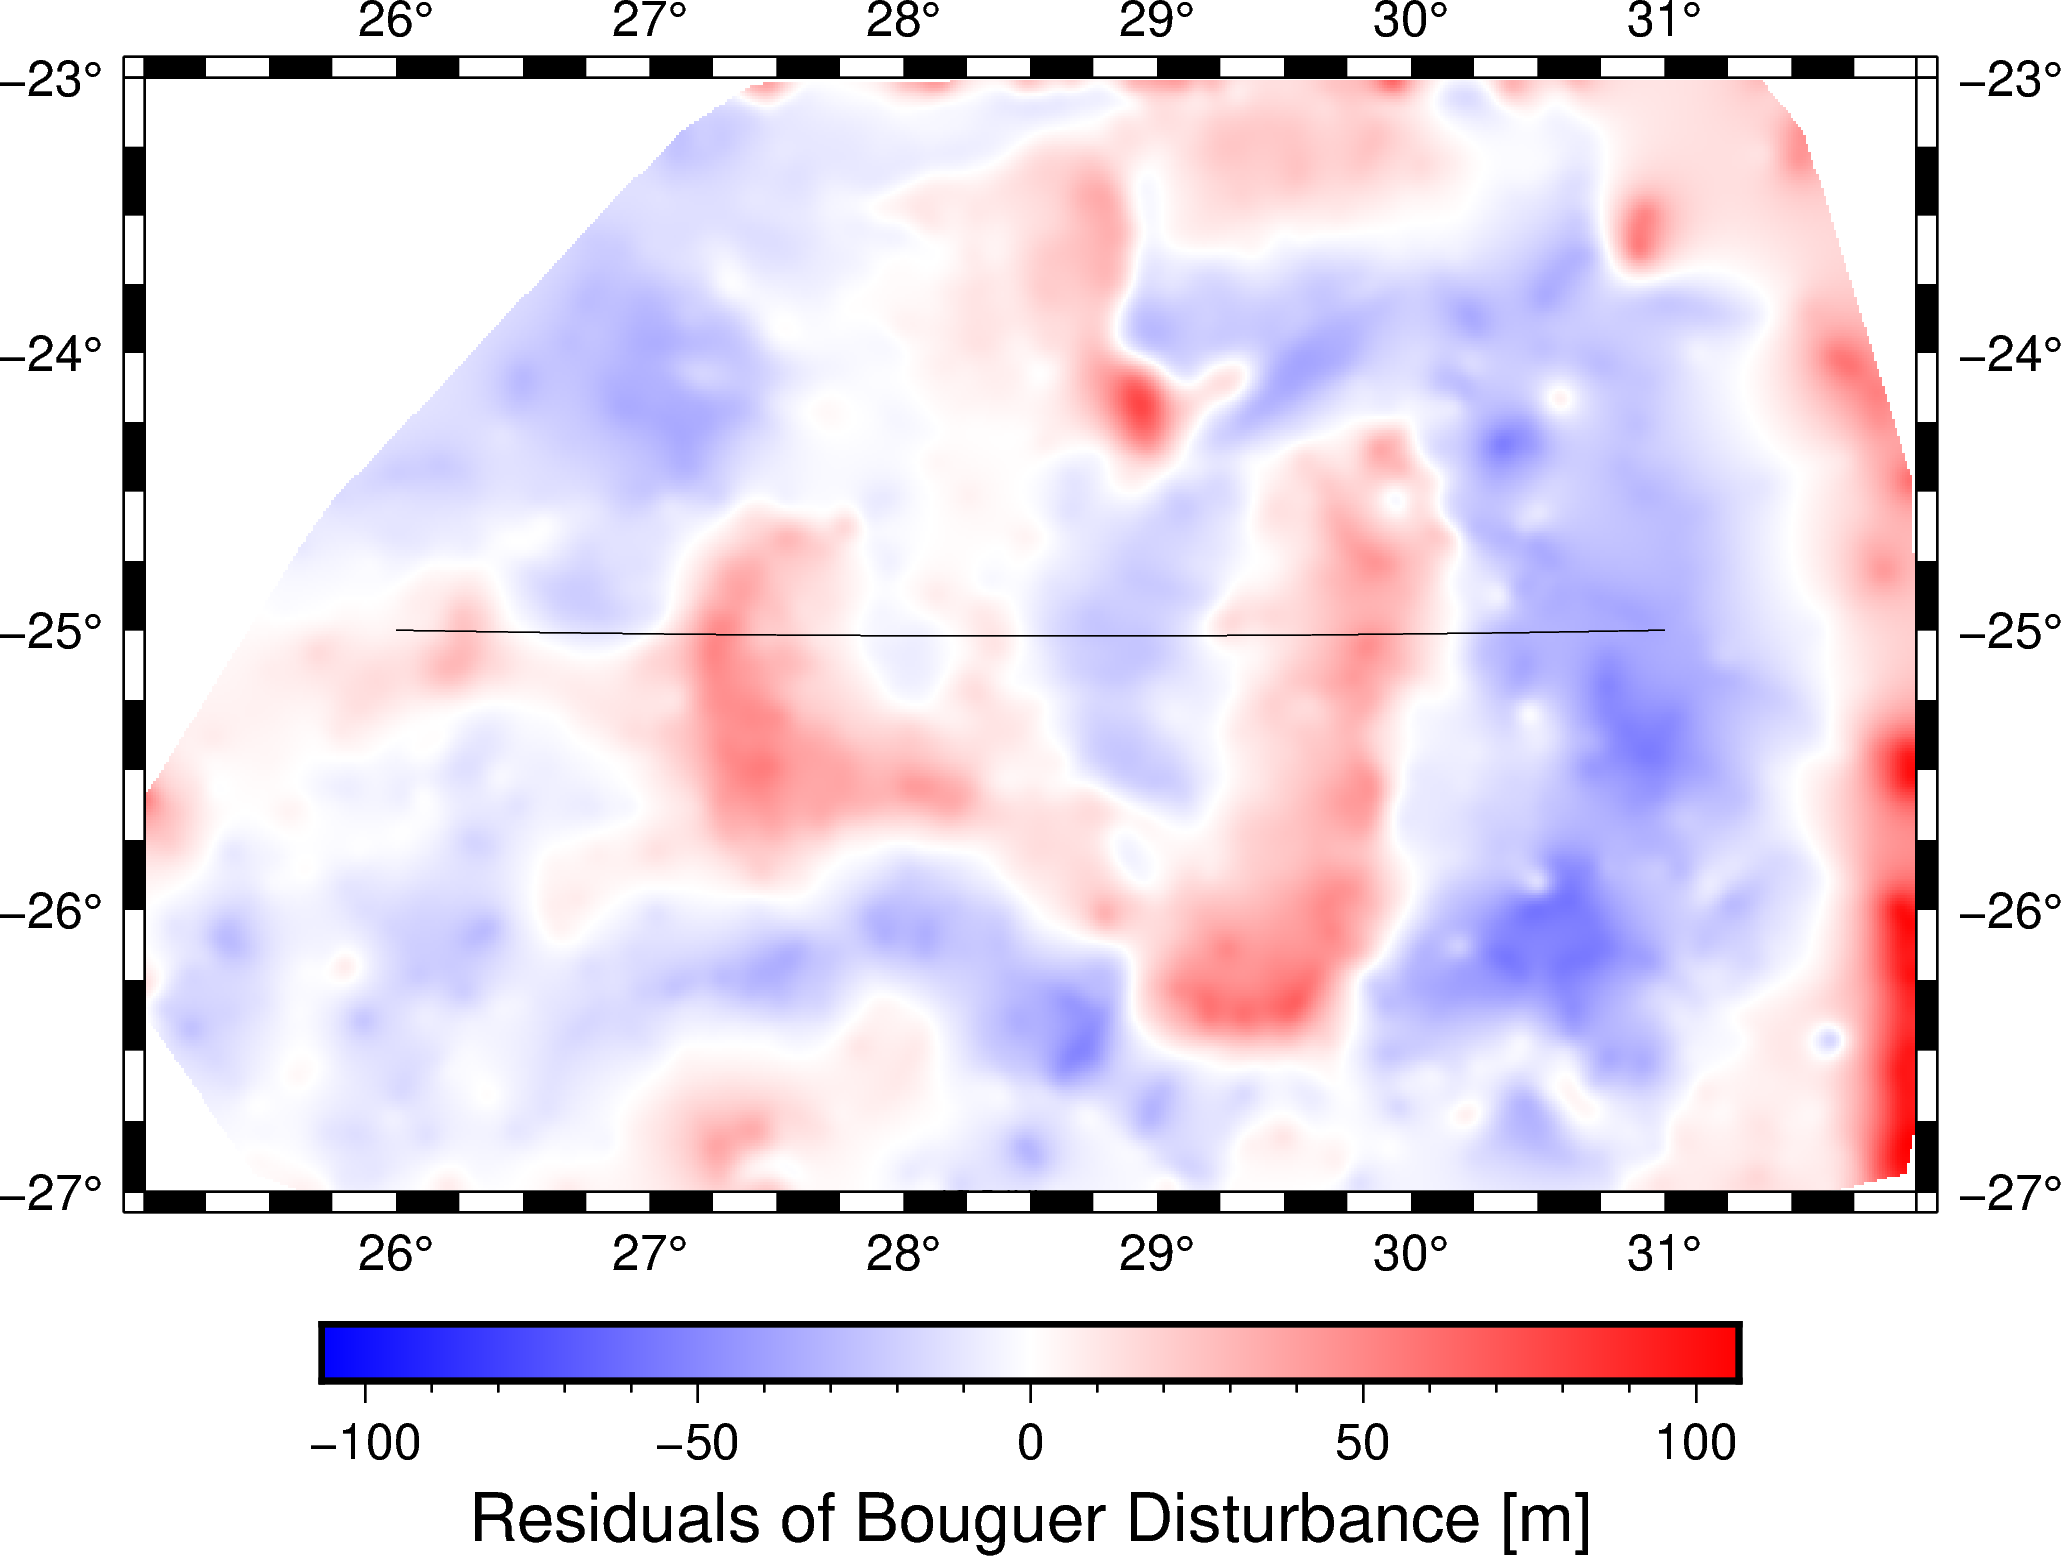

In [30]:
fig = pygmt.Figure()
fig.coast(shorelines=True, region=region_deg)

maxabs = vd.maxabs(grid.bouguer_residuals)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.grdimage(grid.bouguer_residuals, nan_transparent=True, projection=projection_gmt)

x = [p[0] for p in (point1, point2)]
y = [p[1] for p in (point1, point2)]
fig.plot(x=x, y=y, projection=projection_gmt)

fig.basemap(projection=projection_gmt, frame=True)
fig.colorbar(frame='af+l"Residuals of Bouguer Disturbance [m]"')
fig.show()

## Save results

In [31]:
data.to_csv("south-africa-gravity-disturbance.csv")

In [32]:
grid.to_netcdf("south-africa-residuals.nc")